### **Python Code: DEEP Waterbury Calibration focus on each PA site**


In [1]:
# File created by Tim K. Keyes, Ph.D. of EGBANA and Rea Domingo of SHU for Sierra Club CT, 2022-23

# Load the libraries
from pathlib import Path
import math

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
import statsmodels.api as sm  # https://www.statsmodels.org/stable/index.html
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.optimize import minimize,Bounds,BFGS,SR1,minimize_scalar
from scipy.stats import ks_2samp # ROC and KS
from scipy.stats import boxcox # Box-Cox transformation, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

# datetime
from datetime import datetime, tzinfo, timedelta, date
from dateutil.tz import tzutc, tzlocal
import pytz

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')



## **Data Reading and Cleaning**

In [64]:
# Load the dataset
# Converting to CSV from Excel and reading into python may insert spaces; better to read it directly from Excel
#File = pd.read_excel('C:/Users/timke/Documents/Professional/Misc Research Materials/Hazardous Liquid Accidents/PurpleAir/Data Viz/WB-GT outer join 2021-1H2022 v10.xlsx') #Name of the file
#File = pd.read_excel('C:/Users/timke/Documents/Professional/Misc Research Materials/Hazardous Liquid Accidents/PurpleAir/Data Viz/WB-LM outer join 2021-1H2022 v10.xlsx') #Name of the file
File = pd.read_excel('C:/Users/timke/Documents/Professional/Misc Research Materials/Hazardous Liquid Accidents/PurpleAir/Data Viz/WB-LZ outer join 2021-1H2022 v10.xlsx') #Name of the file
File.head()

PM25                      UTC     UTC_day   UTC_mo  WeeksSince    UCT_hr  \
0   8.3  2021-01-01 05:00:00 UTC  2021-01-01  2021-01           0  05:00:00   
1  10.7  2021-01-01 06:00:00 UTC  2021-01-01  2021-01           0  06:00:00   
2  12.5  2021-01-01 07:00:00 UTC  2021-01-01  2021-01           0  07:00:00   
3  14.2  2021-01-01 08:00:00 UTC  2021-01-01  2021-01           0  08:00:00   
4  15.7  2021-01-01 09:00:00 UTC  2021-01-01  2021-01           0  09:00:00   

   DOW  UTC_yr               created_at  PM25_CF1_ug/m3  ...   L3H_Temp  \
0    5    2021  2021-01-01 05:00:00 UTC           14.00  ...  34.430000   
1    5    2021  2021-01-01 06:00:00 UTC           24.22  ...  34.430000   
2    5    2021  2021-01-01 07:00:00 UTC           40.48  ...  33.880000   
3    5    2021  2021-01-01 08:00:00 UTC           28.52  ...  33.396667   
4    5    2021  2021-01-01 09:00:00 UTC           24.34  ...  32.520000   

      L3H_RH  L3H_WindSpd L3H_Pressure  Yday_PM2.5  Yday_Temp    Yday_RH  \
0  60.430000          0.0     0.000000         NaN        NaN        NaN   
1  60.430000          0.0    29.610000   17.267895  35.933158  57.302105   
2  61.215000          6.0    29.610000   17.267895  35.933158  57.302105   
3  62.143333          6.0    29.620000   17.267895  35.933158  57.302105   
4  63.510000          4.0    29.626667   17.267895  35.933158  57.302105   

   Yday_WindSpd  Yday_Precip  Yday_Press  
0           NaN          NaN         NaN  
1      3.833333          0.0   29.639444  
2      3.833333          0.0   29.639444  
3      3.833333          0.0   29.639444  
4      3.833333          0.0   29.639444  

[5 rows x 62 columns]

In [65]:
# Rows and Columns of data
File.shape

(13104, 62)

In [66]:
# Check for missing observations...
File.isna().sum()

PM25            322
UTC               0
UTC_day           0
UTC_mo            0
WeeksSince        0
               ... 
Yday_Temp         1
Yday_RH          25
Yday_WindSpd      1
Yday_Precip       1
Yday_Press        6
Length: 62, dtype: int64

In [67]:
File.dtypes

PM25            float64
UTC              object
UTC_day          object
UTC_mo           object
WeeksSince        int64
                 ...   
Yday_Temp       float64
Yday_RH         float64
Yday_WindSpd    float64
Yday_Precip     float64
Yday_Press      float64
Length: 62, dtype: object

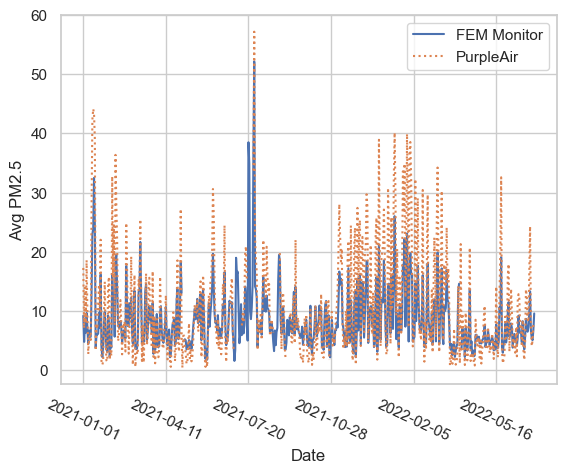

In [68]:
# Time Series Plots

# Plot PA and PA_PM25AMT by Day
File.groupby(['UTC_day'])['PM25'].mean().plot(legend=True, label="FEM Monitor")
File.groupby(['UTC_day'])['PM25_ATM_ug/m3'].mean().plot(legend=True, xlabel="Date",ylabel="Avg PM2.5", label="PurpleAir",style=":")
# Rotating X-axis labels
plt.xticks(rotation = -25)
plt.show()

In [7]:
# Create key functions repeatedly used

# Quantile (Decile) means...

def plot_quantile_means(x,y,brksize,xlabel,ylabel,title_name=''):
    tmp = pd.DataFrame({x.name:x,y.name:y},columns = [x.name,y.name])
    tmp = tmp[~tmp.isna()]
    tmp.sort_values(x.name)
    qtl = np.quantile(tmp[x.name],np.arange(0,1+brksize,brksize))
    n = qtl.size-1
    qtlmeans = np.arange(1,n+1)*1.0
    qtlmids  = np.arange(1,n+1)*1.0
    for i in np.arange(n):
        x1 = qtl[i]
        x2 = qtl[i+1]
        if (i==n-1):
            qtlmids[i] = tmp[(tmp[x.name]>=x1)&(tmp[x.name]<=x2)][x.name].mean()
            qtlmeans[i] = tmp[(tmp[x.name]>=x1)&(tmp[x.name]<=x2)][y.name].mean()
        else:
            qtlmids[i] = tmp[(tmp[x.name]>=x1)&(tmp[x.name]<x2)][x.name].mean()
            qtlmeans[i] = tmp[(tmp[x.name]>=x1)&(tmp[x.name]<x2)][y.name].mean()  
    plot_title = "Number of quantiles: %d" %n
    qtlmids = qtlmids[~np.isnan(qtlmids)]
    qtlmeans = qtlmeans[~np.isnan(qtlmeans)]
    plt.plot(qtlmids,qtlmeans,color = 'black',linestyle = '-',marker = 'o')
    result = sm.OLS(qtlmeans,sm.add_constant(qtlmids)).fit()
    plt.plot(qtlmids,result.params[0]+qtlmids*result.params[1],'--')
    for xc in qtl:
        plt.axvline(x=xc,color ='red',linestyle = '--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#    plt.title(plot_title+'\n'+title_name) # COMMENT OUT TITLES IF NOT NEEDED....
 # comment out the line below to make x axis fit better   
#    plt.xlim(qtlmids[0]*0.7-10e-2,qtlmids[qtlmids.size-1]*1.2)
    plt.show()

# KS-ROC...
def evaluate_ks_and_roc_auc(y_real, y_proba):
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba
   
    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
   
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'] , df['proba'])
   
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
   
       
     #Plot the ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve( y_real, y_proba,
                                              drop_intermediate = False )
    plt.figure(figsize=(8, 5))
    label= f"ROC AUC = {roc_auc:.4f}" + '\n'
    label+= f"KS = {ks.statistic:.4f}"
    plt.plot( fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC = Receiver Operating Characteristic for Decision Tree Model')
    plt.legend(loc="lower right")
    plt.show()
   
    return ks.statistic, roc_auc

In [8]:
# Dropping rows with missing variables (0), blank everything.
#df = File.dropna()
df = File.dropna(subset=['PM25','PM25_ATM_ug/m3',
                            'Temperature_F','Humidity_%',
                            'precip','snowfall','GrossLoad','OA_Oxford_Cap','OA_Oxford_nom',
                            'HrlyPrecip','HrlyViz','HrlyWindSpd','HrlyPress',
                            'WindNW','WindSW','WindNE',
                            'Temp_c','RH_c','L3H_precip','CPV_1','CPV_2','CPV_3','CPV_maxmin','OA_1','OA_2','OA_3','OA_maxmin',
                            'L3H_PM2.5','L3H_Temp','L3H_RH','L3H_WindSpd','L3H_Pressure',
                            'Yday_PM2.5','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_Precip','Yday_Press'])
df
len(df)

7725

In [54]:
# No missing anymore
df.isna().sum()
#df['PM25_ATM_ug/m3'].isna().sum()

PM25          0
UTC           0
UTC_day       0
UTC_mo        0
WeeksSince    0
             ..
Timeofday     0
tot_precip    0
CPV_nom       0
OA_nom        0
Morning       0
Length: 80, dtype: int64

In [10]:
# UTC column changed to datetime object
# Humidity_% changed to float from object
df['UTC'] = pd.to_datetime(df['UTC'])

df.head(5)

PM25                       UTC     UTC_day   UTC_mo  WeeksSince  \
2539   2.4 2021-04-17 00:00:00+00:00  2021-04-17  2021-04          15   
2540   1.8 2021-04-17 01:00:00+00:00  2021-04-17  2021-04          15   
2541   2.4 2021-04-17 02:00:00+00:00  2021-04-17  2021-04          15   
2542   2.8 2021-04-17 03:00:00+00:00  2021-04-17  2021-04          15   
2543   2.4 2021-04-17 04:00:00+00:00  2021-04-17  2021-04          15   

        UCT_hr  DOW  UTC_yr        FirstOfcreated_at  PM25_CF1_ug/m3  ...  \
2539  00:00:00    6    2021  2021-04-17 00:00:00 UTC           75.90  ...   
2540  01:00:00    6    2021  2021-04-17 01:00:00 UTC           22.33  ...   
2541  02:00:00    6    2021  2021-04-17 02:00:00 UTC            6.22  ...   
2542  03:00:00    6    2021  2021-04-17 03:00:00 UTC            1.24  ...   
2543  04:00:00    6    2021  2021-04-17 04:00:00 UTC            0.08  ...   

       L3H_Temp     L3H_RH  L3H_WindSpd L3H_Pressure  Yday_PM2.5  Yday_Temp  \
2539  73.576667  25.286667     9.333333    28.826667   93.766667  42.447083   
2540  74.720000  24.906667     9.000000    28.840000   93.766667  42.447083   
2541  74.966667  24.856667     8.333333    28.856667   93.766667  42.447083   
2542  74.676667  24.556667     7.666667    28.880000   93.766667  42.447083   
2543  74.400000  24.223333     6.333333    28.893333   93.766667  42.447083   

        Yday_RH  Yday_WindSpd  Yday_Precip  Yday_Press  
2539  90.035833      8.541667         0.46    28.94625  
2540  90.035833      8.541667         0.46    28.94625  
2541  90.035833      8.541667         0.46    28.94625  
2542  90.035833      8.541667         0.46    28.94625  
2543  90.035833      8.541667         0.46    28.94625  

[5 rows x 62 columns]

## **ADDING key Variables**

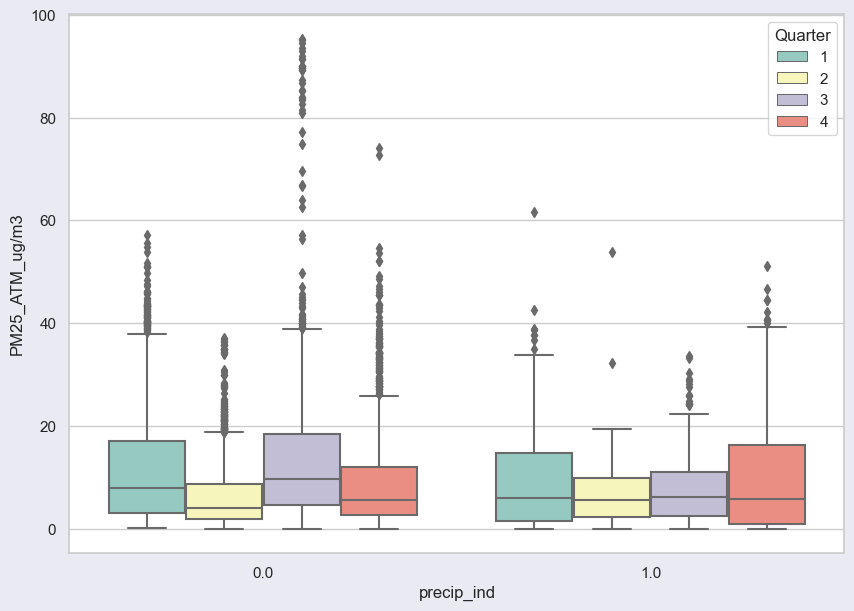

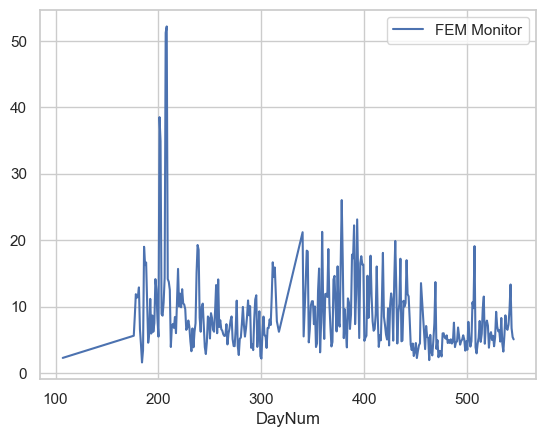

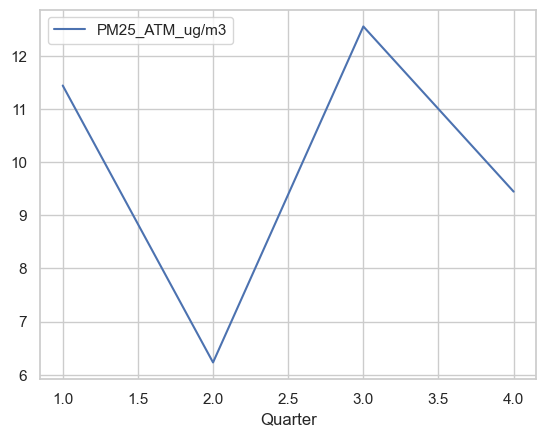

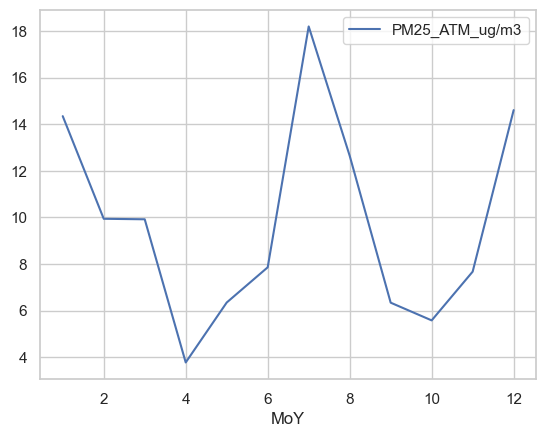

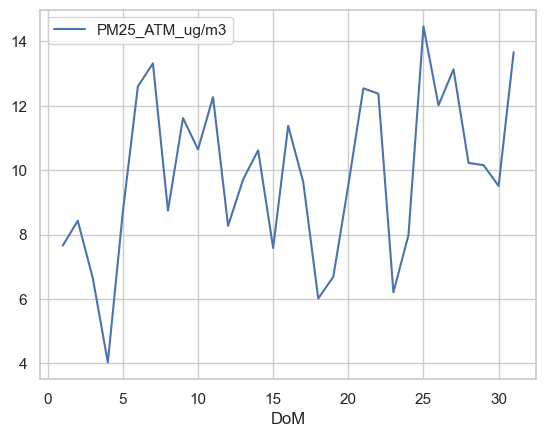

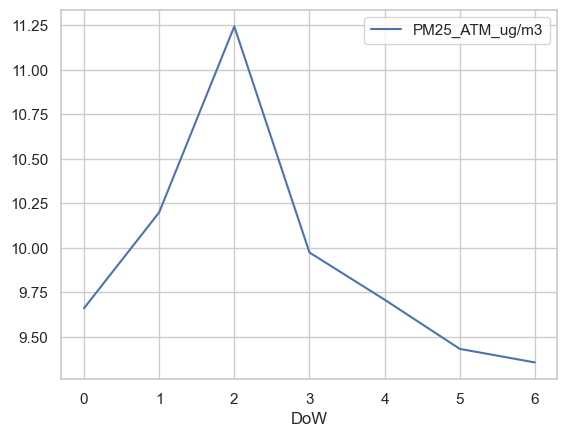

In [52]:
# Column with Quarter, Day of Week, Year, etc.

df['Quarter'] = df['UTC'].dt.quarter # 4 Quarter
df['Year'] = df['UTC'].dt.year
df['Month'] = df['UTC'].dt.month
df['Day'] = df['UTC'].dt.day

def diff_dates(date1, date2):
    return abs(date2-date1).days

df['DayNum']=np.zeros(len(df))
df['precip_ind']=np.zeros(len(df))
for i in range(1,len(df)+1):
    df['DayNum'].iloc[i-1] = diff_dates(date(2020,12,31),date(df['Year'].iloc[i-1],df['Month'].iloc[i-1],df['Day'].iloc[i-1]))
    if df['L3H_precip'].iloc[i-1] > 0: df['precip_ind'].iloc[i-1]=1

#print(df['DayNum'])
#print(df['precip_ind'])

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 7), facecolor=facecolor)
ax = sns.boxplot(data=df, palette='Set3', x="precip_ind", y='PM25_ATM_ug/m3', hue='Quarter')
plt.show()

#print(df.head(25))

# Plot PA and PA_PM25AMT by Day
df.groupby(['DayNum'])['PM25'].mean().plot(legend=True, label="FEM Monitor")
df.groupby(['DayNum'])['PM25_ATM_ug/m3'].mean().plot(legend=True, xlabel="Day of Study", ylabel="Avg PM2.5", label="PurpleAir",style=":")
plt.show()

# Plot PA_PM25ATM with Qtr
df.groupby(['Quarter'])['PM25_ATM_ug/m3'].mean().plot(legend=True)
plt.show()

# Assign for Month of Year
df['MoY'] = df['UTC'].dt.month
df['MoY4'] = np.where(df['MoY'] == 4, 1, 0) # dummy variable for low points
df['MoY7'] = np.where(df['MoY'] == 7, 1, 0) # dummy for the high point
df['MoY10'] = np.where(df['MoY'] == 10, 1, 0)
df.groupby(['MoY'])['PM25_ATM_ug/m3'].mean().plot(legend=True)
plt.show()

# Look for the Day of Month
df['DoM'] = df['UTC'].dt.day
df.groupby(['DoM'])['PM25_ATM_ug/m3'].mean().plot(legend=True)
plt.show()


# 0 is Monday and 6 is Sunday
df['DoW'] = df['UTC'].dt.weekday 
df['Weekday'] = np.where(df['DoW'] < 5, 1, 0) # Less than 5(Saturday) to get the Weekdays
df.groupby(['DoW'])['PM25_ATM_ug/m3'].mean().plot(legend=True)
plt.show()

# Link for datetime: https://docs.python.org/3/library/datetime.html?highlight=datetime#datetime.datetime.hour
df['Timeofday'] = df['UTC'].dt.hour 

# Add rainfall and snowfall into one variable
df['tot_precip']=df['precip']+df['snowfall']

# Normalize CPV Towantic and Oxford Algonquin variables
#df['CPV_norm']=df['GrossLoad'] / np.max(df['GrossLoad'])
#df['OA_norm']=df['OA_Oxford_nom']/df['OA_Oxford_Cap']
df['CPV_nom']=df['GrossLoad']
df['OA_nom']=df['OA_Oxford_nom']

# DAY OF THE YEAR we need another variable calling this

#my_datetime = datetime(2023, 2, 13, 17, 10, 27, tzinfo = pytz.utc)
#print(my_datetime)
# 2023-02-13 17:10:27+00:00
#my_datetime = datetime(df['Year'], df['MoY'], df['DayofMonth'], df['Timeofday'],0,0, tzinfo = pytz.utc)
#print(my_datetime)
# for loop to 

# UTC
#my_datetime_utc = my_datetime.strftime('%Y-%m-%d %H:%M:%S %Z%z')
#print(my_datetime_utc)
#2021-01-16 05:00:00

# Local 
#my_datetime_est = my_datetime.astimezone(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S %Z%z')
#print(my_datetime_est)

#def astimezone(self,tz):
    #if self.tzinfo is tz:
     #   return self
    #utc = (self - self.utcoffset()).replace(tzinfo=tz)
    #return tz.fromutc(utc)

#df['Localdate'] = df['UTC'].astimezone(tzlocal())
#df['TimeofdayLoc'] = df['Localdate'].dt.hour 
df['Morning'] = np.where(df['Timeofday'] < 16, 1, 0) # Less than 16 since it is Greenwich, UK
#print(df.Timeofday,df.Localdate,df.TimeofdayLoc)
#df.head(5)


In [47]:
# Compute key descriptive statistics
#df['Temperature_F'].describe()
df['DayNum'].describe() # DayNum is used for analysis done on daily basis, as opposed to hourly

count    7725.000000
mean      362.871068
std       110.360054
min       107.000000
25%       263.000000
50%       372.000000
75%       460.000000
max       545.000000
Name: DayNum, dtype: float64

In [48]:
# Main Dataframe with all the important variables of the study
# PM25_ATM_ug/m3 to study too. We are using PM25_CF1_ug/m3
#main_df = pd.DataFrame(np.c_[df['PM25'],df['PM25_ATM_ug/m3'],df['GrossLoad'],df['Operating Time'],df['HeatInput'],
#                            df['SO2_mass'],df['CO2_mass'],df['NOx_mass'],df['OA_Oxford_nom'],df['Temperature_F'],df['Humidity_%'],
#                            df['Quarter'],df['Weekday'],df['Morning'],df['Year'],df['MoY'],df['MoY4'],df['MoY7'],df['MoY10'],
#                            df['DoW'],df['Timeofday'],df['DoM'],df['NG_consume'], df['tot_precip'],
#                            df['MMBTU'], df['HrlyPrecip'],df['HrlyViz'],df['HrlyWindDir_Ind'],df['HrlyWindSpd'],
#                            df['CPV_norm'], df['OA_norm'], df['WindNW'], df['WindSW'], df['WindNE']],
#                            columns = ['WB_PM25','PA_PM25','GrossLoad','OpTime','HeatInput',
#                            'SO2_mass','CO2_mass','NOx_mass','OA_Oxford_nom','Temp_F',
#                            'RH','Quarter','Weekday','Morning','Year','MoY','MoY4','MoY7',
#                            'MoY10','DoW','TimeofDay','DoM','NG_consume','tot_precip','MMBTU','HrlyPrecip','HrlyViz','HrlyWindDir_Ind','HrlyWindSpd',
#                            'CPV_norm','OA_norm','WindNW','WindSW','WindNE'])
                            # again, we could expand this list...OR compress it

# USE CODE ABOVE IF STARTING EXPLORATION; USE CODE BELOW AS MODELING REFINEMENTS SUGGEST...

main_df = pd.DataFrame(np.c_[df['DayNum'],df['PM25'],df['PM25_ATM_ug/m3'],
                            df['Temperature_F'],df['Humidity_%'],
                            df['Quarter'],df['DoW'],df['Weekday'],df['Morning'],df['MoY'],
                            df['tot_precip'],df['HrlyPrecip'],df['HrlyViz'],df['HrlyWindSpd'],df['HrlyPress'],
                            df['CPV_nom'], df['OA_nom'], df['WindNW'], df['WindSW'], df['WindNE'],
                            df['Temp_c'],df['RH_c'],df['L3H_precip'],df['precip_ind'],df['CPV_1'],df['CPV_2'],df['CPV_3'],df['CPV_maxmin'],
                            df['OA_1'],df['OA_2'],df['OA_3'],df['OA_maxmin'],
                            df['L3H_PM2.5'],df['L3H_Temp'],df['L3H_RH'],df['L3H_WindSpd'],df['L3H_Pressure'],
                            df['Yday_Temp'],df['Yday_RH'],df['Yday_WindSpd'],df['Yday_Precip'],df['Yday_PM2.5'],df['Yday_Press']],
                            columns = ['DayNum','WB_PM25','PA_PM25',
                            'Temp_F','RH',
                            'Quarter','DoW','Weekday','Morning','MoY',
                            'tot_precip','HrlyPrecip','HrlyViz','HrlyWindSpd','HrlyPress',
                            'CPV_nom','OA_nom','WindNW','WindSW','WindNE',
                            'Temp_c','RH_c','L3H_precip','precip_ind','CPV_1','CPV_2','CPV_3','CPV_maxmin','OA_1','OA_2','OA_3','OA_maxmin',
                            'L3H_PM2.5','L3H_Temp','L3H_RH','L3H_WindSpd','L3H_Pressure',
                            'Yday_Temp','Yday_RH','Yday_WindSpd','Yday_Precip','Yday_PM2.5','Yday_Press'])    

# When UTC is added data types are changed
print(main_df.head(5))
print(len(main_df))

   DayNum  WB_PM25  PA_PM25  Temp_F     RH  Quarter  DoW  Weekday  Morning  \
0   107.0      2.4    53.78   75.00  25.00      2.0  5.0      0.0      1.0   
1   107.0      1.8    21.80   74.03  24.67      2.0  5.0      0.0      1.0   
2   107.0      2.4     6.22   75.00  24.00      2.0  5.0      0.0      1.0   
3   107.0      2.8     1.24   74.17  24.00      2.0  5.0      0.0      1.0   
4   107.0      2.4     0.08   74.00  24.00      2.0  5.0      0.0      1.0   

   MoY  ...   L3H_Temp     L3H_RH  L3H_WindSpd  L3H_Pressure  Yday_Temp  \
0  4.0  ...  73.576667  25.286667     9.333333     28.826667  42.447083   
1  4.0  ...  74.720000  24.906667     9.000000     28.840000  42.447083   
2  4.0  ...  74.966667  24.856667     8.333333     28.856667  42.447083   
3  4.0  ...  74.676667  24.556667     7.666667     28.880000  42.447083   
4  4.0  ...  74.400000  24.223333     6.333333     28.893333  42.447083   

     Yday_RH  Yday_WindSpd  Yday_Precip  Yday_PM2.5  Yday_Press  
0  90.035833  

In [49]:
# Main Dataframe has to data types conversion to be done - THIS DATAFRAME HAS MAXIMUM REMOVAL FOR MISSING
main_df.dtypes

DayNum          float64
WB_PM25         float64
PA_PM25         float64
Temp_F          float64
RH              float64
Quarter         float64
DoW             float64
Weekday         float64
Morning         float64
MoY             float64
tot_precip      float64
HrlyPrecip      float64
HrlyViz         float64
HrlyWindSpd     float64
HrlyPress       float64
CPV_nom         float64
OA_nom          float64
WindNW          float64
WindSW          float64
WindNE          float64
Temp_c          float64
RH_c            float64
L3H_precip      float64
precip_ind      float64
CPV_1           float64
CPV_2           float64
CPV_3           float64
CPV_maxmin      float64
OA_1            float64
OA_2            float64
OA_3            float64
OA_maxmin       float64
L3H_PM2.5       float64
L3H_Temp        float64
L3H_RH          float64
L3H_WindSpd     float64
L3H_Pressure    float64
Yday_Temp       float64
Yday_RH         float64
Yday_WindSpd    float64
Yday_Precip     float64
Yday_PM2.5      

## ** LCF REGRESSION DATA ** ##

13104
PM25           0
UTC            0
UTC_day        0
UTC_mo         0
WeeksSince     0
              ..
Yday_Precip    0
Yday_Press     5
Year           0
Month          0
Day            0
Length: 65, dtype: int64
8499


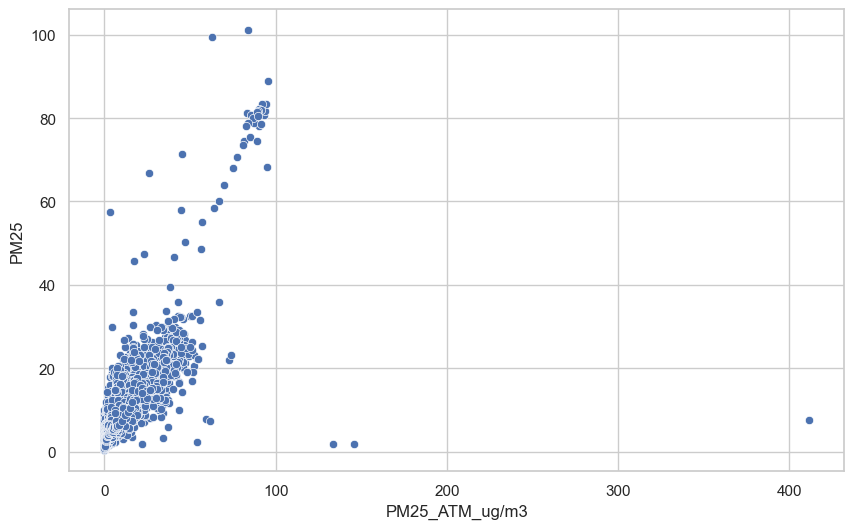

376


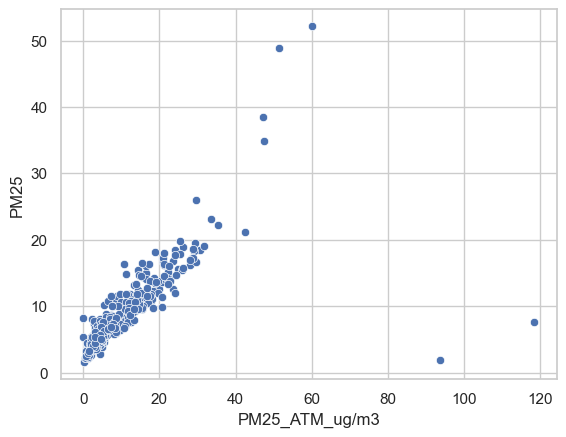

In [50]:
# Create LCF-only data frame for HOURLY data - don't need explanatory variables...but note that LCF will be based on a dataset
# different from that used in the the explanatory regressions

print(len(File))
lcf_df=File.dropna(subset=['PM25','PM25_ATM_ug/m3'])
#lcf_df=File.dropna(subset=['PM25_ATM_ug/m3'])

lcf_df['UTC'] = pd.to_datetime(lcf_df['UTC'])
lcf_df['Year'] = lcf_df['UTC'].dt.year
lcf_df['Month'] = lcf_df['UTC'].dt.month
lcf_df['Day'] = lcf_df['UTC'].dt.day

print(lcf_df.isna().sum())
print(len(lcf_df))

# Scatterplot between WTB PM25 and LM PM25
fig, ax = plt.subplots(figsize=(10, 6))

#ax = sns.scatterplot(data=main_df, palette='Set3', x="PA_PM25", y='WB_PM25')
ax = sns.scatterplot(data=lcf_df, palette='Set3', x="PM25_ATM_ug/m3", y='PM25')
# Values of PM25_CF1_ug/m3 >= 200 will be considered outliers see chart below
plt.show()

# Create LCF-only data from for DAILY data...
lcf_df['DayNum']=np.zeros(len(lcf_df))
for i in range(1,len(lcf_df)+1):
    lcf_df['DayNum'].iloc[i-1] = diff_dates(date(2020,12,31),date(lcf_df['Year'].iloc[i-1],lcf_df['Month'].iloc[i-1],lcf_df['Day'].iloc[i-1]))

lcfd_df=lcf_df.groupby('DayNum').mean() # create LCF daily data frame
print(len(lcfd_df))

ax = sns.scatterplot(data=lcfd_df, palette='Set3', x="PM25_ATM_ug/m3", y='PM25')
plt.show()

## Exploratory Data Analysis (EDA)

**Waterbury monitor by each PA sensor THIS COULD BE BASED ON LCF DATASET**

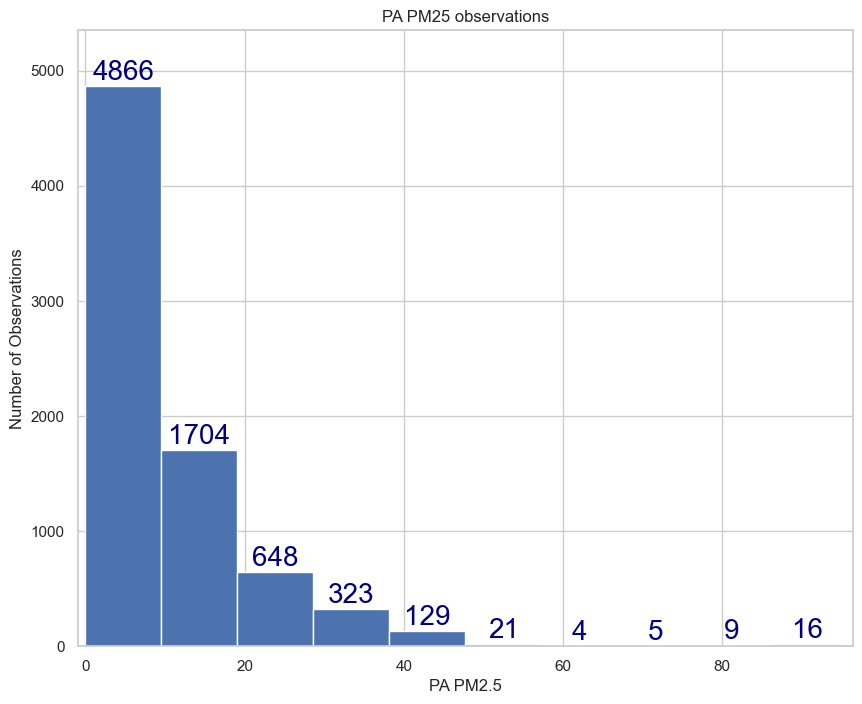

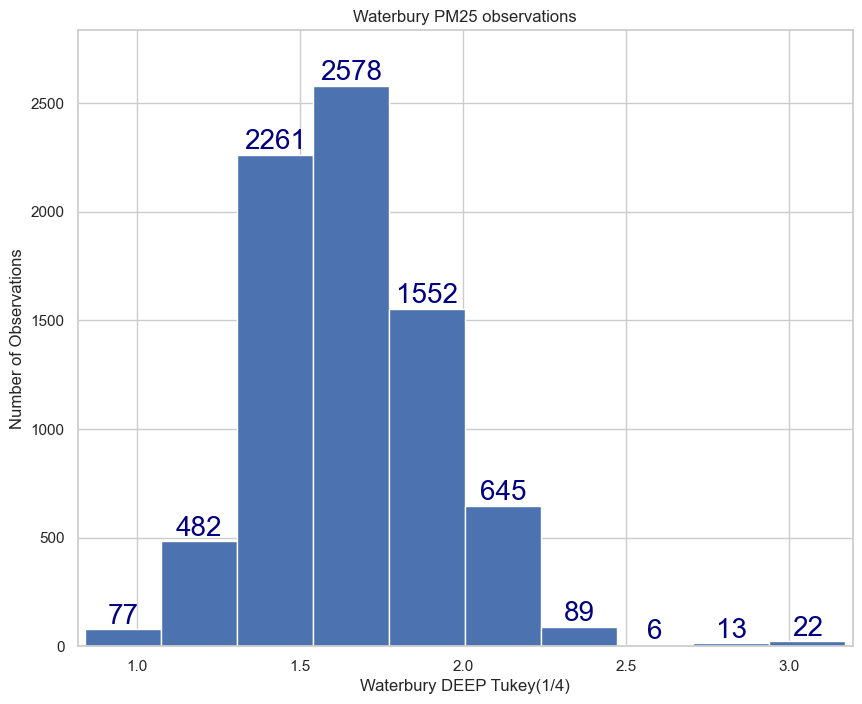

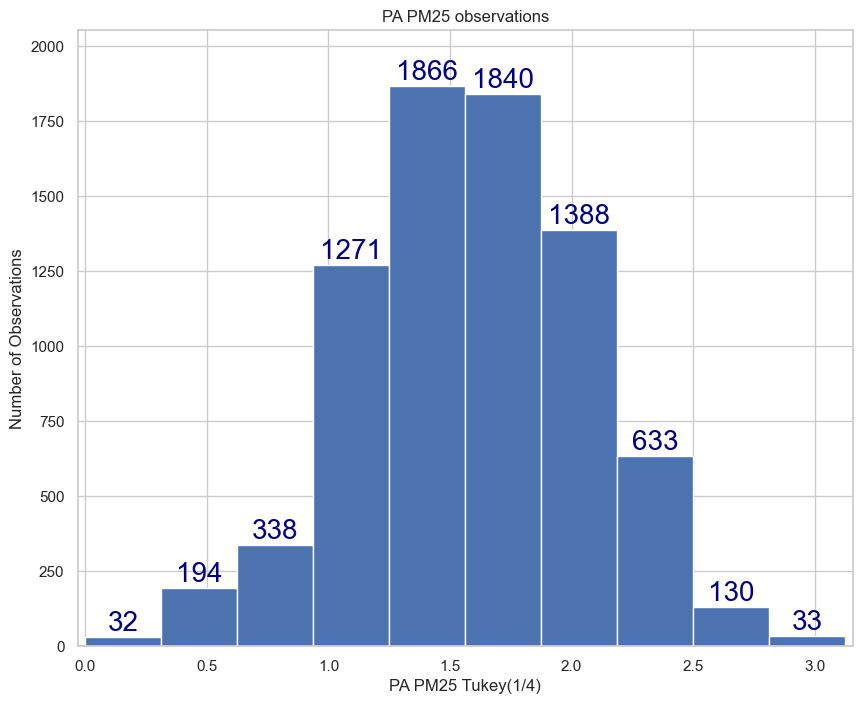

In [16]:
plt.figure(figsize=(10, 8))
#Note that X label should in 10s
#values, bins, bars = plt.hist(df['Age'], edgecolor='white')
values, bins, bars = plt.hist(main_df['PA_PM25'],bins=10, edgecolor='white')
plt.bar_label(bars, fontsize=20, color='navy')
plt.xlabel("PA PM2.5")
plt.ylabel("Number of Observations")
plt.title("PA PM25 observations")

plt.margins(x=0.01, y=0.1)
plt.show()

plt.figure(figsize=(10, 8))
#Note that X label should in 10s
#values, bins, bars = plt.hist(df['Age'], edgecolor='white')
main_df["WB_PM25_bc"]=(main_df['WB_PM25']**(0.25) - 1) / 0.25
main_df["WB_PM25_tu"]=main_df['WB_PM25']**(0.25)
values, bins, bars = plt.hist(main_df["WB_PM25_tu"],bins=10, edgecolor='white')
plt.bar_label(bars, fontsize=20, color='navy')
plt.xlabel("Waterbury DEEP Tukey(1/4)")
plt.ylabel("Number of Observations")
plt.title("Waterbury PM25 observations")

plt.margins(x=0.01, y=0.1)
plt.show()

plt.figure(figsize=(10, 8))
#Note that X label should in 10s
#values, bins, bars = plt.hist(df['Age'], edgecolor='white')
#tmp=boxcox(main_df['PA_PM25'], lmbda=0.25)
# https://www.statisticshowto.com/probability-and-statistics/normal-distributions/box-cox-transformation/
main_df["PA_PM25_bc"]=(main_df['PA_PM25']**(0.25) - 1) / 0.25
main_df["PA_PM25_tu"]=main_df['PA_PM25']**(0.25)
values, bins, bars = plt.hist(main_df["PA_PM25_tu"],bins=10, edgecolor='white')
plt.bar_label(bars, fontsize=20, color='navy')
plt.xlabel("PA PM25 Tukey(1/4)")
plt.ylabel("Number of Observations")
plt.title("PA PM25 observations")

plt.margins(x=0.01, y=0.1)
plt.show()

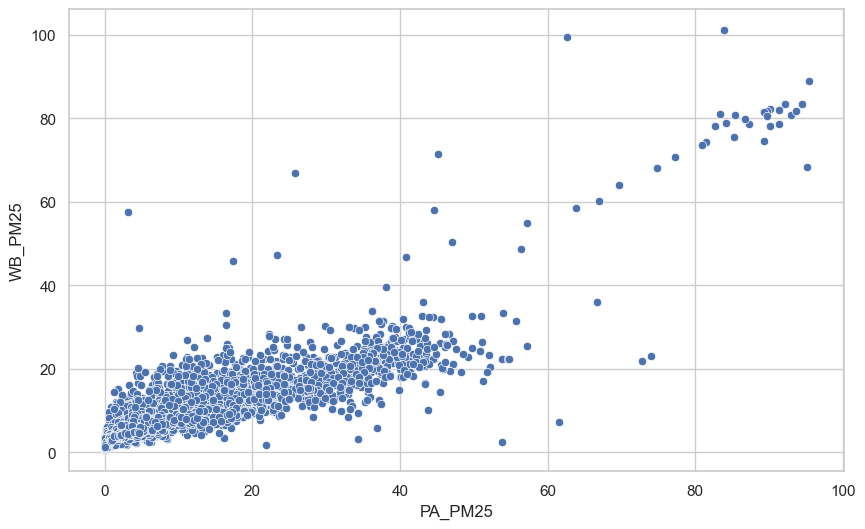

In [17]:
# Scatterplot between WTB PM25 and PA PM25 from main_df FOR HOURLY DATA
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.scatterplot(data=main_df, palette='Set3', x="PA_PM25", y='WB_PM25')
# Values of PM25_CF1_ug/m3 >= ~200 will be considered outliers see chart below

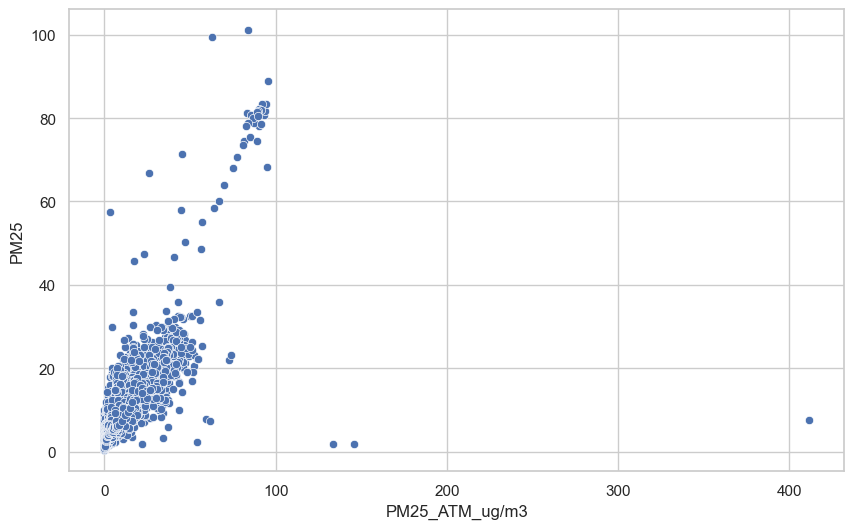

In [18]:
# Scatterplot between WTB PM25 and PA PM25 from lcf_df; DOES THIS FIGURE DIFFER FROM ABOVE? IF YES, IT'S 
# OWING TO REMOVAL OF MISSING VALUES IN main_df
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.scatterplot(data=lcf_df, palette='Set3', x="PM25_ATM_ug/m3", y='PM25')
# Values of PM25_CF1_ug/m3 >= ~100 will be considered outliers see chart below

**UNIVARIATE ANALYSES**

WB_PM25         0
PA_PM25         0
Quarter         0
MoY             0
DoW             0
Weekday         0
Morning         0
Temp_c          0
RH_c            0
HrlyPrecip      0
HrlyViz         0
HrlyWindSpd     0
HrlyPress       0
WindNW          0
WindSW          0
WindNE          0
CPV_nom         0
OA_nom          0
L3H_precip      0
CPV_maxmin      0
OA_maxmin       0
L3H_PM2.5       0
L3H_Temp        0
L3H_RH          0
L3H_WindSpd     0
Yday_Temp       0
Yday_RH         0
Yday_WindSpd    0
Yday_Precip     0
Yday_Press      0
Yday_PM2.5      0
dtype: int64
7725


<AxesSubplot:>

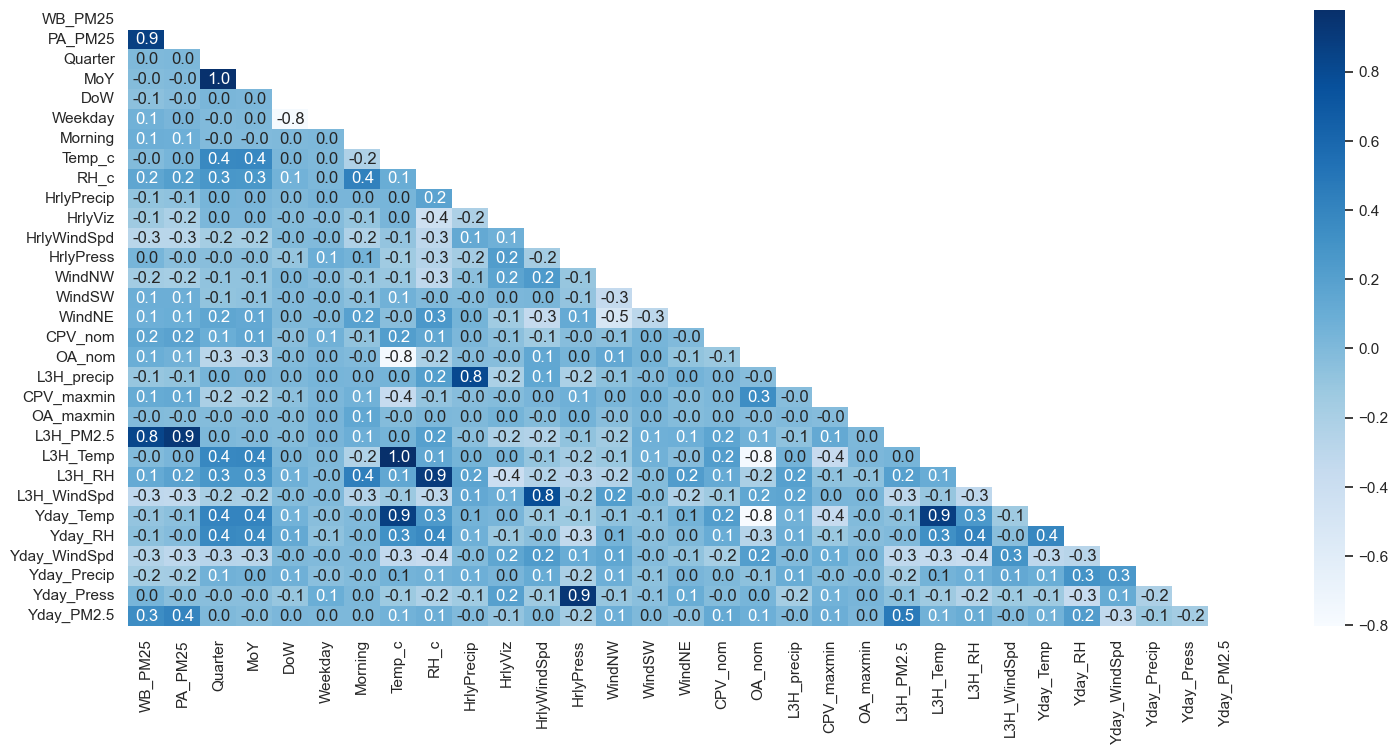

In [19]:
# Heatmap
# Check the correlation among all variables (PERHAPS THIS SHOULD ONLY INCLUDE MAIN EFFECTS AS WITH SCATTERPLOTS)
#corr = main_df.corr(method='pearson')
#ler_df=File.dropna(subset=['PM25','PM25_ATM_ug/m3'])
corr_df = main_df[['WB_PM25','PA_PM25',
                            'Quarter','MoY','DoW','Weekday','Morning',
                            'Temp_c','RH_c','HrlyPrecip','HrlyViz','HrlyWindSpd','HrlyPress','WindNW','WindSW','WindNE',
                            'CPV_nom','OA_nom',
                            'L3H_precip','CPV_maxmin','OA_maxmin',
                            'L3H_PM2.5','L3H_Temp','L3H_RH','L3H_WindSpd','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_Precip','Yday_Press','Yday_PM2.5']]
corr_df=corr_df.dropna()
print(corr_df.isna().sum())

corr=corr_df.corr(method='pearson')
print(len(corr_df))
                           
# Create a lower trimatrix of take the bottom triangle since it repeats itself
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, axs = plt.subplots(figsize=(18,8))
#sns.heatmap(corr, annot=True,  mask = mask, cmap='Blues')
sns.heatmap(corr, annot=True,  mask = mask, cmap='Blues',fmt=".1f")

# Notice the high correlation with the Towantic Dataset, decided to use GrossLoad for Towantic Variables

In [20]:
# Scatterplot of variable vs variable
# QUARTER
temp = main_df.groupby(['Quarter']).mean() # Can be changed to Weekday, Morning
print(temp)
# Lowest in the 2nd Quarter and highest in the 3rd quarter 

             DayNum    WB_PM25    PA_PM25     Temp_F         RH       DoW  \
Quarter                                                                     
1.0      410.483543   9.978025  11.444782  39.625644  51.358040  2.953533   
2.0      483.698405   6.186370   6.229773  68.460860  51.119821  2.923635   
3.0      227.045764  10.099951  12.557303  77.125842  62.440360  3.056962   
4.0      317.705729   8.746094   9.446797  53.891296  59.266868  3.039714   

          Weekday   Morning        MoY  tot_precip  ...  Yday_Temp    Yday_RH  \
Quarter                                             ...                         
1.0      0.723136  0.655857   2.002420    0.226709  ...  39.148807  51.846702   
2.0      0.729338  0.652489   5.111648    0.114804  ...  67.373492  51.905538   
3.0      0.710321  0.645570   7.972736    0.178681  ...  76.769327  62.706042   
4.0      0.723958  0.654297  10.952474    0.160299  ...  53.485130  59.877188   

         Yday_WindSpd  Yday_Precip  Yday_PM2.5  Yd

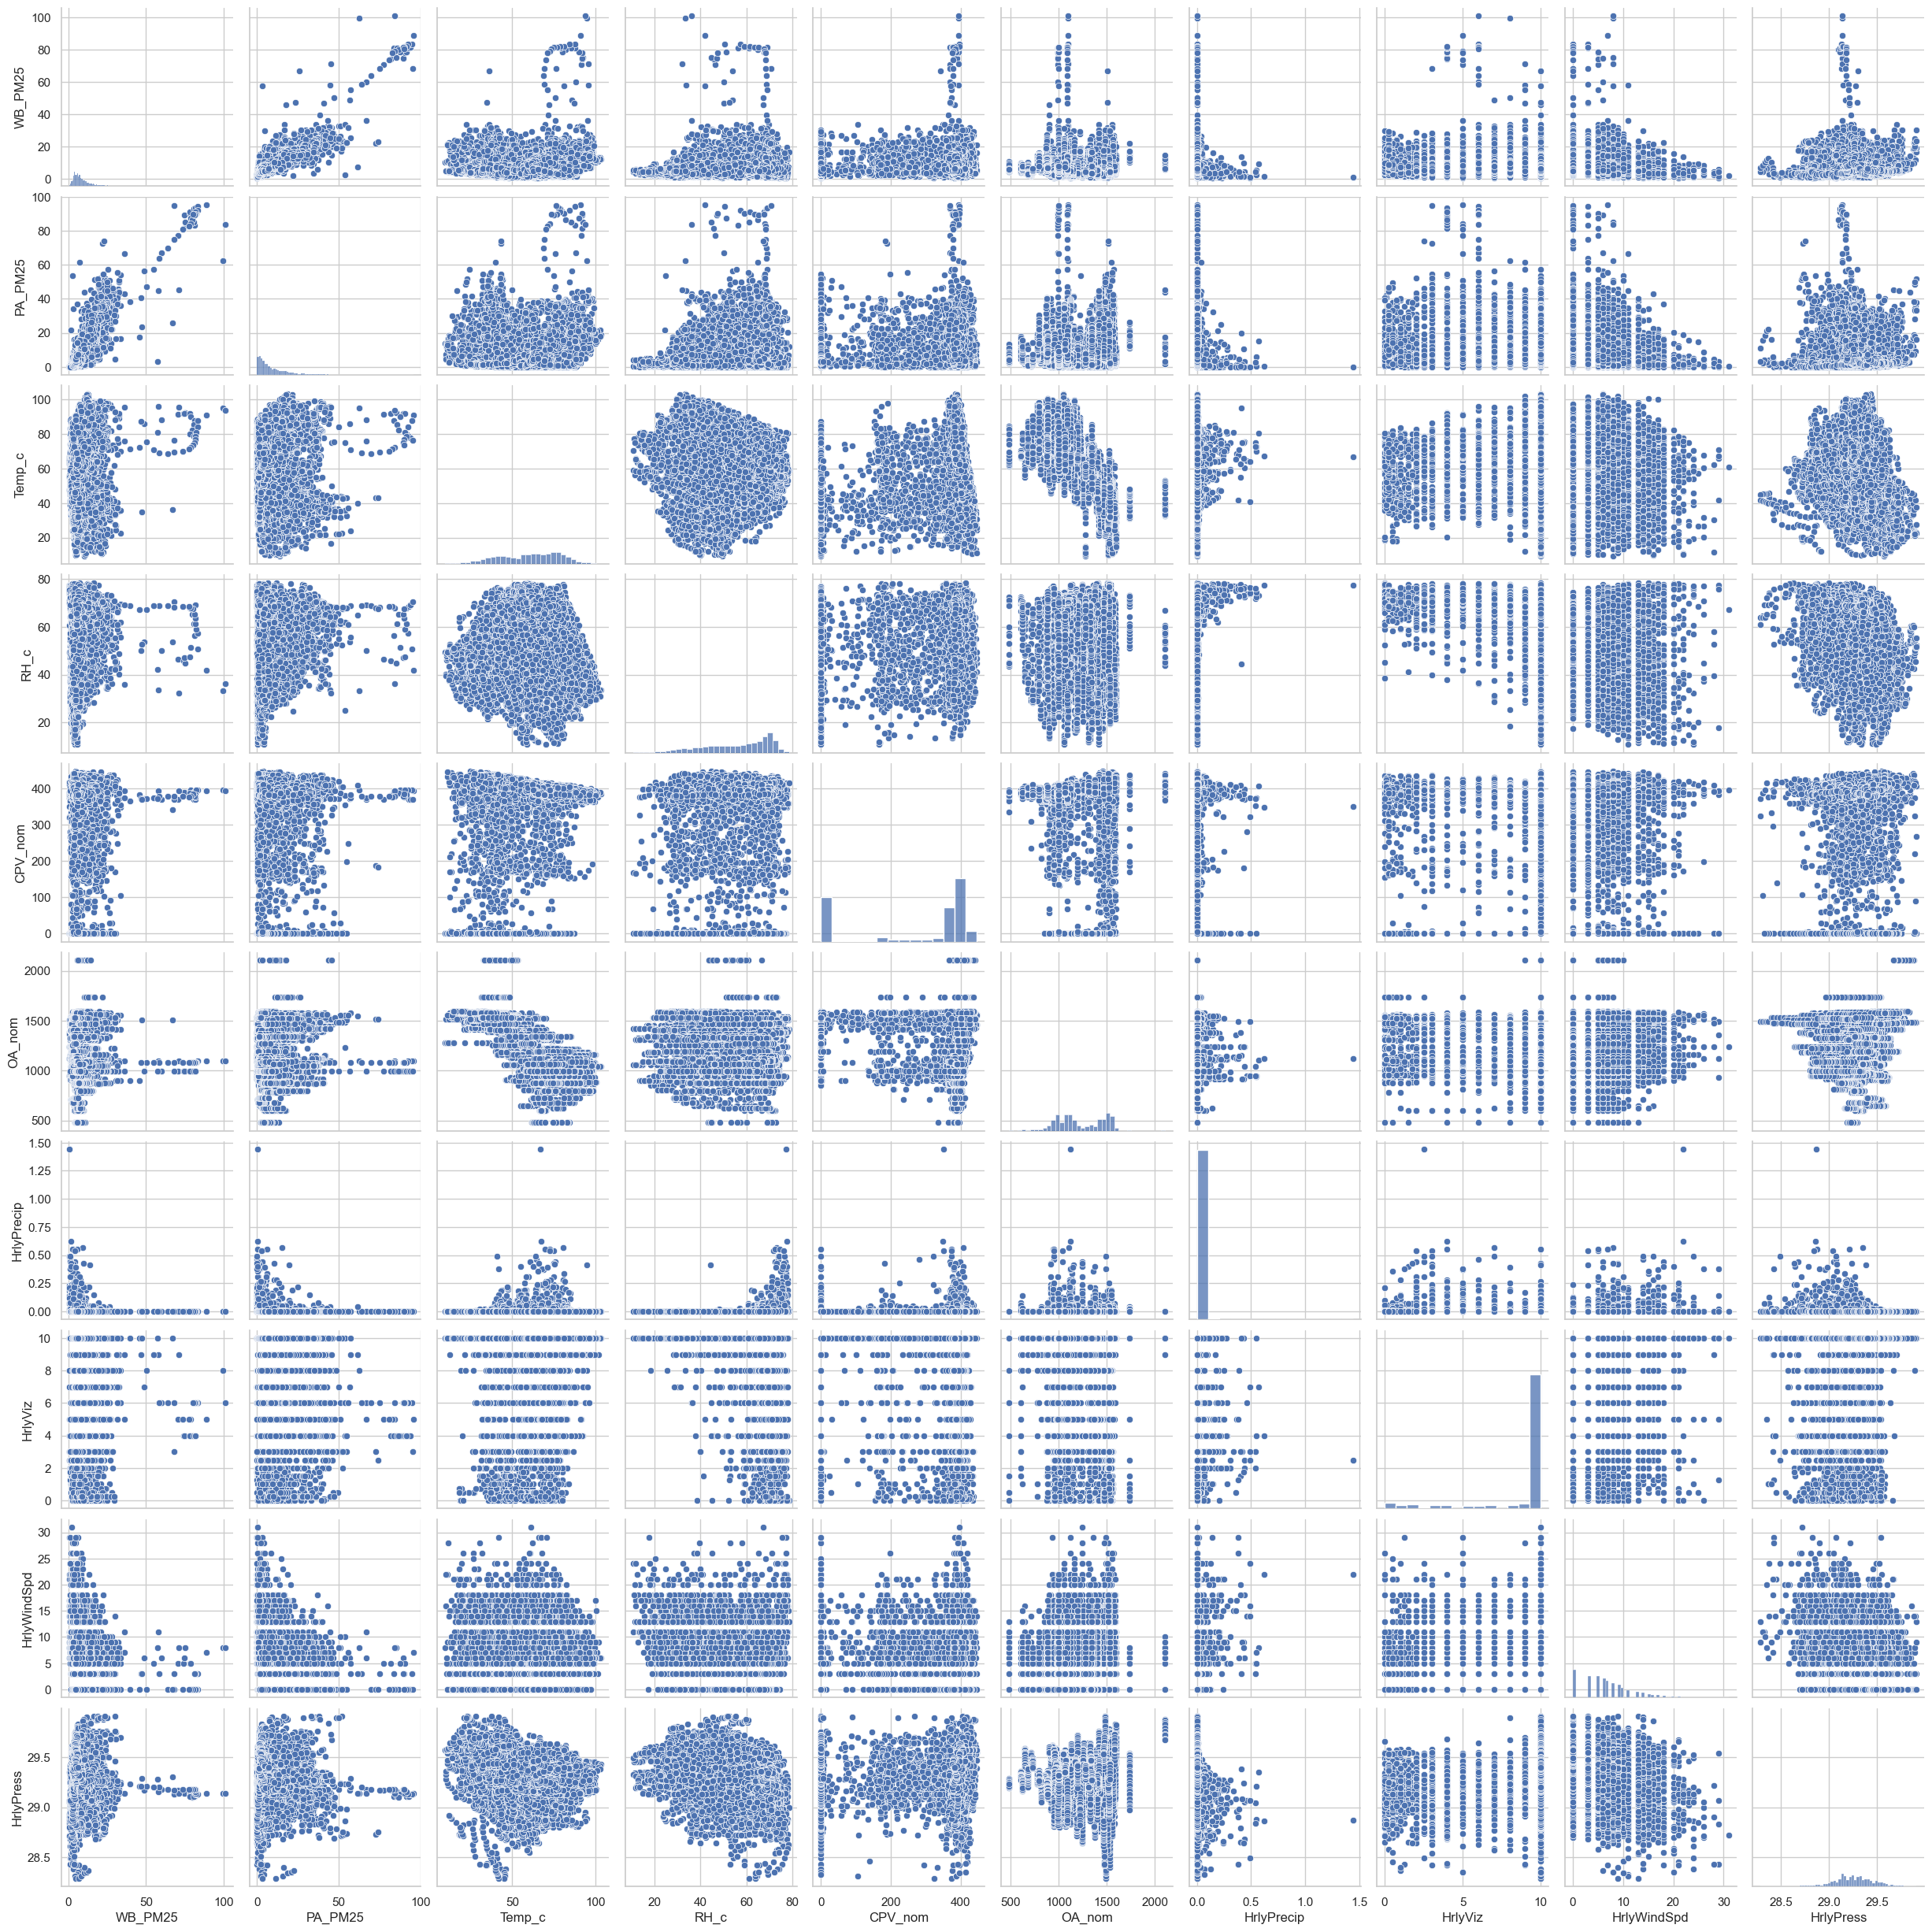

In [21]:
# Pairplots - challenging to interpret...use quantile means...
sns.pairplot(main_df, vars = ['WB_PM25','PA_PM25','Temp_c','RH_c','CPV_nom','OA_nom','HrlyPrecip','HrlyViz','HrlyWindSpd','HrlyPress'], hue=None, palette='pastel')

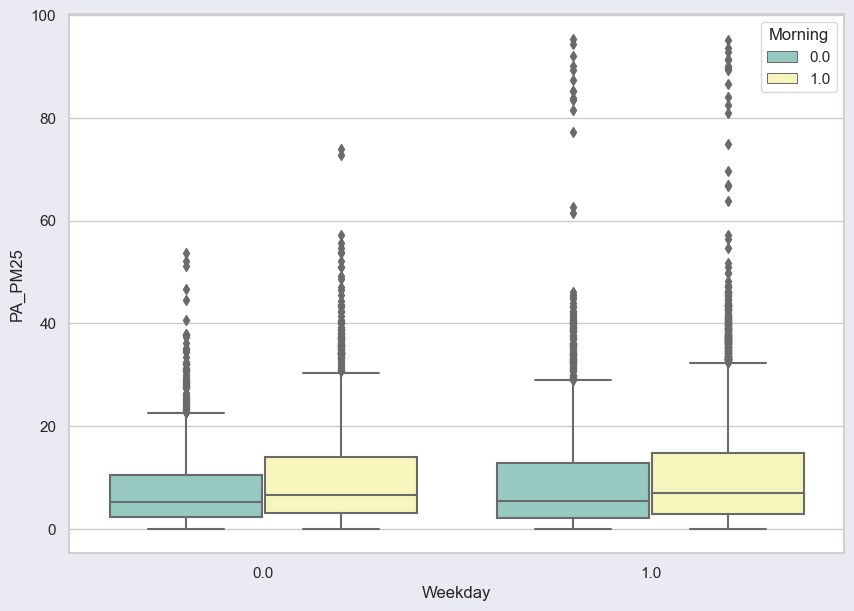

In [22]:
sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 7), facecolor=facecolor)

ax = sns.boxplot(data=main_df, palette='Set3', x="Weekday", y='PA_PM25', hue='Morning')

In [23]:
# Weekday or Morning
temp1 = main_df.groupby(['Weekday']).mean()
print(temp1)

# 1 is weekday
# 0 is weekend

             DayNum   WB_PM25    PA_PM25     Temp_F         RH   Quarter  \
Weekday                                                                    
0.0      356.907950  7.987076   9.394788  60.009916  55.682534  2.404928   
1.0      365.172228  9.044367  10.159510  60.212465  55.863994  2.392716   

              DoW   Morning       MoY  tot_precip  ...  Yday_Temp    Yday_RH  \
Weekday                                            ...                         
0.0      5.498373  0.643887  6.183636    0.186746  ...  60.740967  57.488287   
1.0      2.022246  0.655005  6.209365    0.164595  ...  59.106697  55.906012   

         Yday_WindSpd  Yday_Precip  Yday_PM2.5  Yday_Press  WB_PM25_bc  \
Weekday                                                                  
0.0          6.678069     0.158633    9.879531   29.229217    2.490996   
1.0          6.644176     0.117777   10.063685   29.268599    2.651151   

         WB_PM25_tu  PA_PM25_bc  PA_PM25_tu  
Weekday                        

## Creation of Local Calibration Regression

In [24]:
# Remove Outliers of more than 100 in main_df
model_df = main_df[main_df['PA_PM25'] < 100] # See above for scatterplot justifying outlier removal
model_df

# if doing validation analysis on random sample then select pct to use in modeling
urv=np.random.uniform(0,1,len(model_df))
model_df = model_df[urv<=1.0] # Development dataset; make this cutoff ONE to run ALL DATA

In [25]:
# LCF model needn't have all explanatory predictors; remove outliers of more than 100 in lcf_df
print(lcf_df.dtypes)
print(np.max(lcf_df))
lcf_df=lcf_df[lcf_df['PM25_ATM_ug/m3'] < 100] # strip outliers

# if doing validation analysis on random sample then select pct to use in modeling
urv=np.random.uniform(0,1,len(lcf_df))
lcf_df = lcf_df[urv<=1.0] # Development dataset; make this cutoff ONE to run ALL DATA

print(len(lcf_df))

# X with all the predictors and Y as the outcome
#X = model_df.PA_PM25 
#X = model_df.PA_PM25_tu # Tukey transformed data
X = lcf_df['PM25_ATM_ug/m3'] 
#Y = model_df.WB_PM25
#Y = model_df.WB_PM25_tu # Tukey transformed data
Y = lcf_df.PM25
# Checking the predictors
#print(X,Y)

PM25                      float64
UTC           datetime64[ns, UTC]
UTC_day                    object
UTC_mo                     object
WeeksSince                  int64
                     ...         
Yday_Press                float64
Year                        int64
Month                       int64
Day                         int64
DayNum                    float64
Length: 66, dtype: object
PM25                              101.1
UTC           2022-07-01 04:00:00+00:00
UTC_day                      2022-07-01
UTC_mo                          2022-07
WeeksSince                           78
                        ...            
Yday_Press                    29.849583
Year                               2022
Month                                12
Day                                  31
DayNum                            547.0
Length: 65, dtype: object
8496


                                 OLS Regression Results                                
Dep. Variable:                   PM25   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.863
Method:                 Least Squares   F-statistic:                          5.369e+04
Date:                Wed, 05 Jul 2023   Prob (F-statistic):                        0.00
Time:                        09:27:51   Log-Likelihood:                         -24119.
No. Observations:                8496   AIC:                                  4.824e+04
Df Residuals:                    8495   BIC:                                  4.825e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

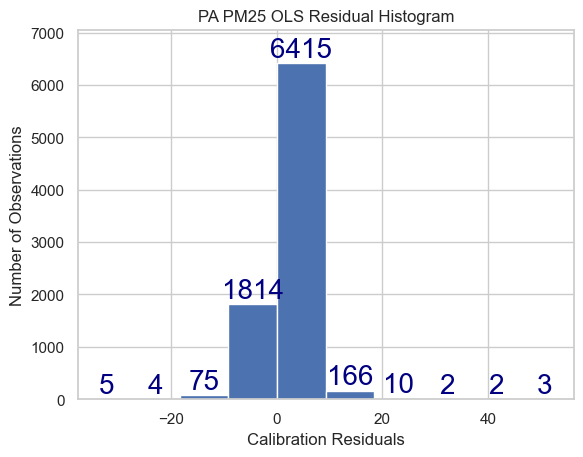

In [26]:
# OLS Regression Results
#X_C = sm.add_constant(X) # adding a column of 1's for the intercept #np.log(X))
#res = sm.OLS(Y, X_C).fit() # Run this line if using INTERCEPT MODEL
res = sm.OLS(Y, X).fit() # very efficient command for OLS
#res = sm.OLS(np.log(Y), X_C).fit() # very efficient command for OLS
print(res.summary())
#Cons = res.params[0] # needed only if running an "intercept" model
#LCF = res.params[1] # ditto
LCF = res.params[0]
#print('Cons:',Cons,'Local Correction Factor: ', LCF)

# Compute misc diagnostic stats (https://www.datatechnotes.com/2019/10/accuracy-check-in-python-mae-mse-rmse-r.html)
Yhat = res.predict(X)
#Yhat = res.predict(X_C) # Run this line if using INTERCEPT MODEL
mae = metrics.mean_absolute_error(Y, Yhat)
mse = metrics.mean_squared_error(Y, Yhat)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(Y,Yhat)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2) #model does not have an intercept/constant term

values, bins, bars = plt.hist(res.resid,bins=10, edgecolor='white')
plt.bar_label(bars, fontsize=20, color='navy')
plt.xlabel("Calibration Residuals")
plt.ylabel("Number of Observations")
plt.title("PA PM25 OLS Residual Histogram")

plt.margins(x=0.01, y=0.1)
plt.show()

374
                                 OLS Regression Results                                
Dep. Variable:                   PM25   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              4894.
Date:                Wed, 05 Jul 2023   Prob (F-statistic):                   1.52e-216
Time:                        09:27:52   Log-Likelihood:                         -911.63
No. Observations:                 374   AIC:                                      1825.
Df Residuals:                     373   BIC:                                      1829.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

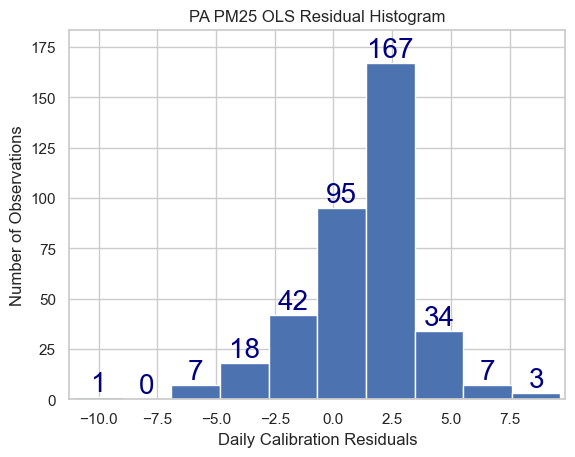

In [27]:
# OLS Regression Results FOR DAILY MODEL

#print(lcfd_df.dtypes)
#print(np.max(lcfd_df))
lcfd_df=lcfd_df[lcfd_df['PM25_ATM_ug/m3'] < 80] # outlier threshold for daily is lower than for hourly

# if doing validation analysis on random sample then select pct to use in modeling
urv=np.random.uniform(0,1,len(lcfd_df))
lcfd_df = lcfd_df[urv<=1.0] # Development dataset; make this cutoff ONE to run ALL DATA

print(len(lcfd_df))

Xd = lcfd_df['PM25_ATM_ug/m3'] 
Yd = lcfd_df.PM25
# Checking the predictors
#print(X,Y)

#Xd_C = sm.add_constant(X) # adding a column of 1's for the intercept #np.log(X))
#res = sm.OLS(Yd, Xd_C).fit() # very efficient command for OLS
resd = sm.OLS(Yd, Xd).fit() # very efficient command for OLS
#res = sm.OLS(np.log(Y), X_C).fit() # very efficient command for OLS
print(resd.summary())
#Cons = res.params[0] # needed only if running an "intercept" model
#LCF = res.params[1] # ditto
LCF_d = resd.params[0]
#print('Cons:',Cons,'Local Correction Factor: ', LCF)

values, bins, bars = plt.hist(resd.resid,bins=10, edgecolor='white')
plt.bar_label(bars, fontsize=20, color='navy')
plt.xlabel("Daily Calibration Residuals")
plt.ylabel("Number of Observations")
plt.title("PA PM25 OLS Residual Histogram")

plt.margins(x=0.01, y=0.1)
plt.show()

## Local Explanatory Regressions

In [28]:
# Cons = intercept if being used; multiply model_df PA_PM2.5 by LCF...

model_df['PA_PM25c'] = (LCF * model_df['PA_PM25']) # Application of the callibrated factor for PA_PM25 - Hrly
model_df['PA_PM25cd'] = (LCF_d * model_df['PA_PM25']) # Daily

# CHECKING DATA MAGNITUDE IMPACT
#model_df['OA_nom']=model_df['OA_nom']/1000

# LCF choice should be consistent with hourly or daily analytics - USE LCF_D for Daily)
model_df.head(5)

#model_df['PA_PM25bc'] = (LCF * model_df['PA_PM25']**(0.25) + (1 - LCF))**4  # Box Cox reverse transformation

# Use PA_PM25c for hourly calibration
y0=np.array(model_df.PA_PM25c) # Creating first variable - this will be exp_dev.PA_PM25c
# Use PA_PM25cd for daily calibration
#y0=np.array(model_df.PA_PM25cd) # Creating first variable - this will be exp_dev.PA_PM25c
y1=np.array(np.zeros(len(model_df.PA_PM25c))) # Creating y1 variable (all set to zero for now) - this will be our target variable of 0/1's
for i in range(1,len(y0)+1):
    if y0[i-1]>=12:  y1[i-1]=1 # Check if 1st variable is >= 12 (Before it was 10) then set 2nd variable to 1; threshold of 12 from PA 

model_df['y1']=y1

print(len(y1))
print(model_df.dtypes)

7725
DayNum          float64
WB_PM25         float64
PA_PM25         float64
Temp_F          float64
RH              float64
Quarter         float64
DoW             float64
Weekday         float64
Morning         float64
MoY             float64
tot_precip      float64
HrlyPrecip      float64
HrlyViz         float64
HrlyWindSpd     float64
HrlyPress       float64
CPV_nom         float64
OA_nom          float64
WindNW          float64
WindSW          float64
WindNE          float64
Temp_c          float64
RH_c            float64
L3H_precip      float64
precip_ind      float64
CPV_1           float64
CPV_2           float64
CPV_3           float64
CPV_maxmin      float64
OA_1            float64
OA_2            float64
OA_3            float64
OA_maxmin       float64
L3H_PM2.5       float64
L3H_Temp        float64
L3H_RH          float64
L3H_WindSpd     float64
L3H_Pressure    float64
Yday_Temp       float64
Yday_RH         float64
Yday_WindSpd    float64
Yday_Precip     float64
Yday_PM2.5 

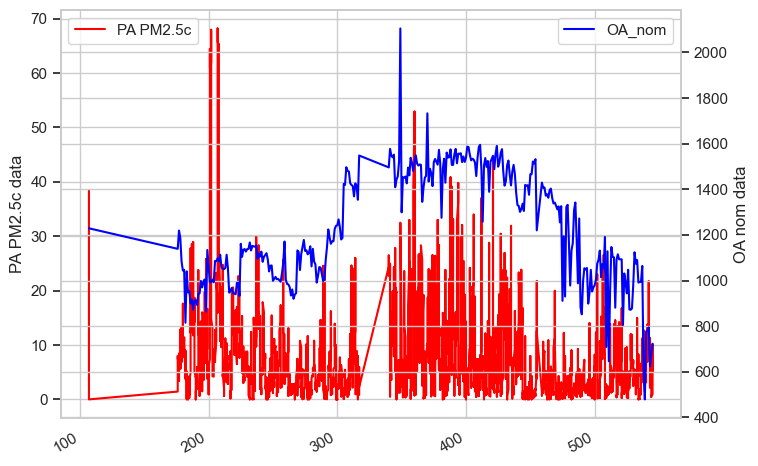

In [29]:
# plot variables

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.set_ylabel("PA PM2.5c data")
ax2.set_ylabel("OA nom data")
ax1.plot(model_df.DayNum, model_df.PA_PM25c, color = 'red', label = 'PA PM2.5c')
ax2.plot(model_df.DayNum, model_df.OA_nom, color = 'blue', label = 'OA_nom')
fig.autofmt_xdate()

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

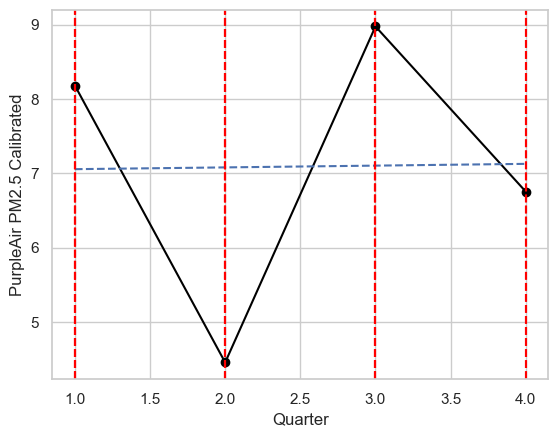

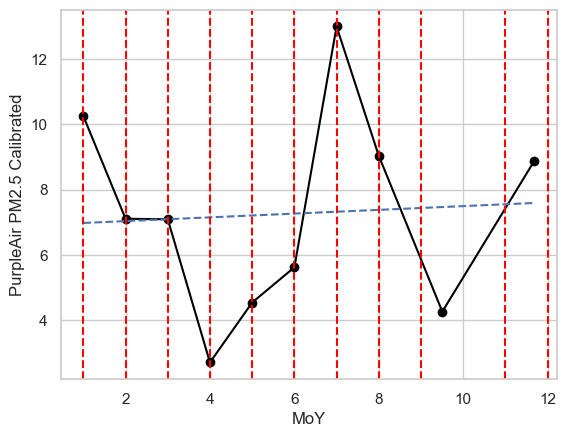

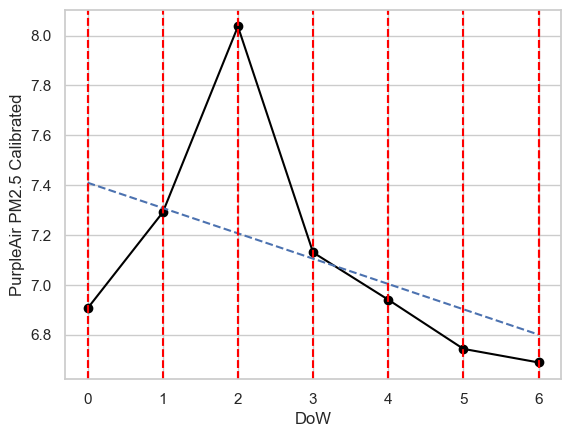

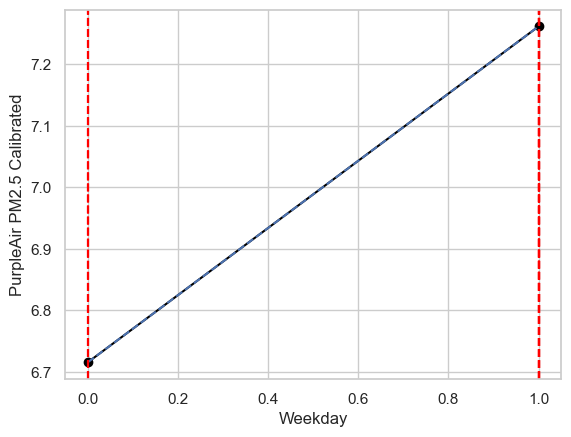

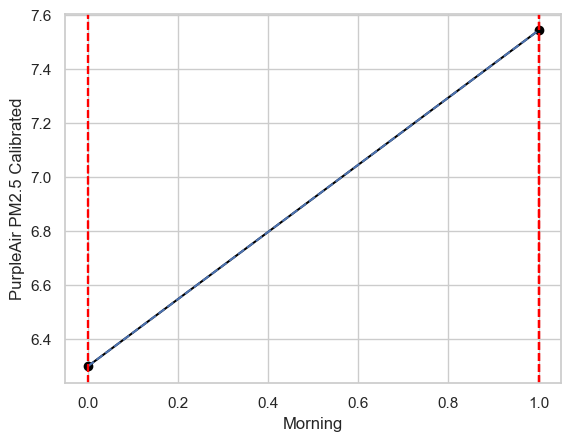

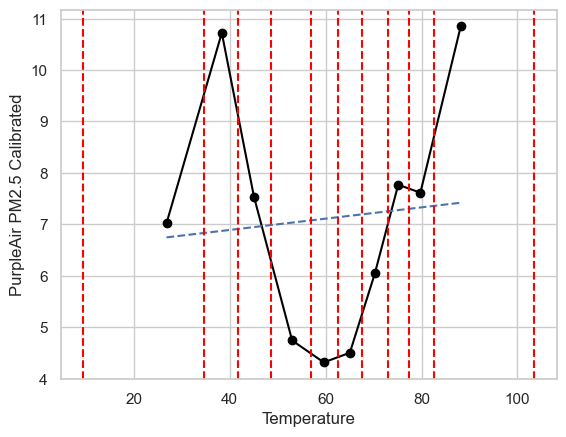

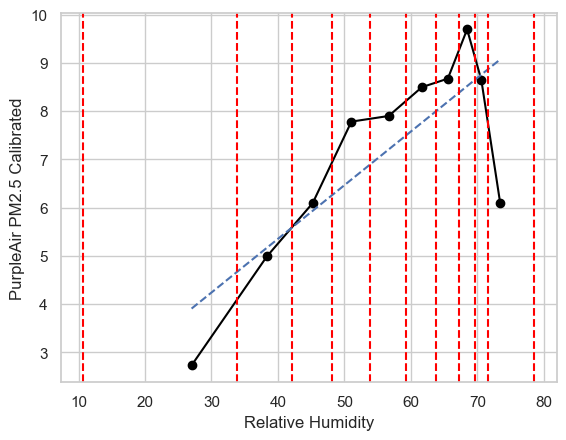

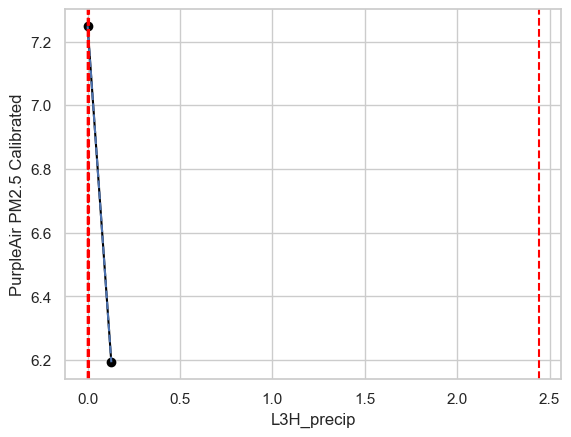

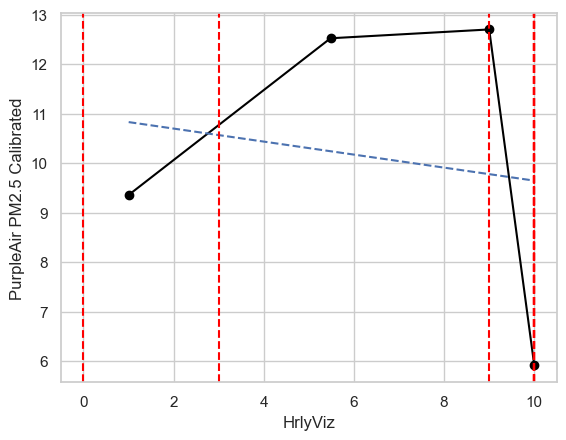

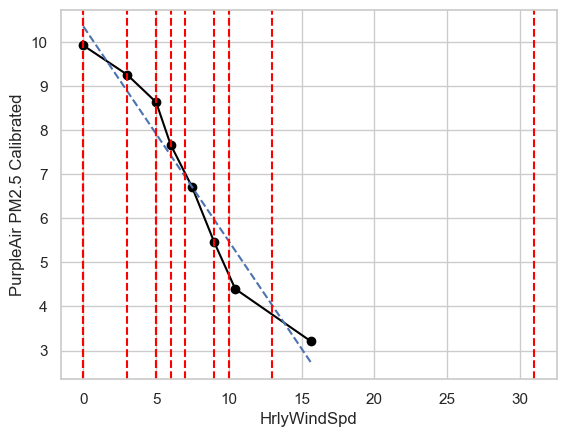

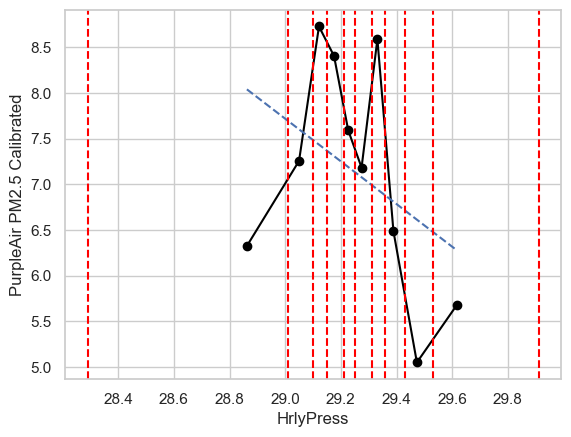

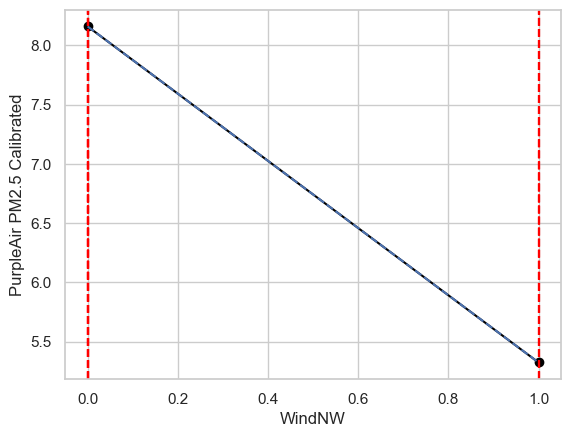

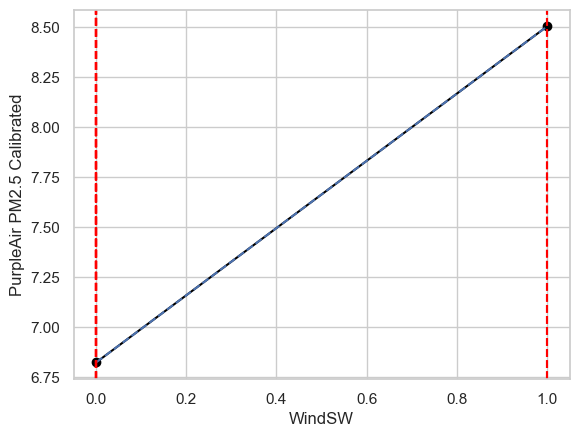

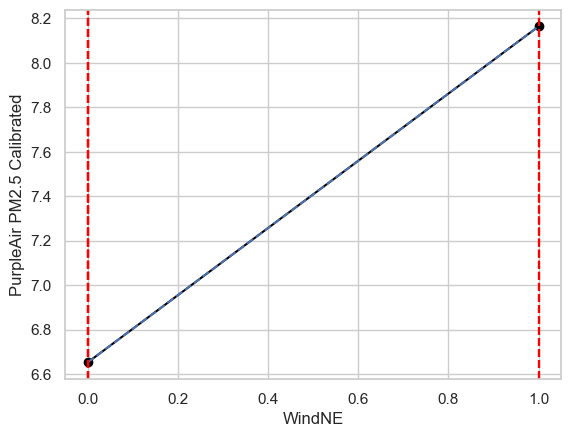

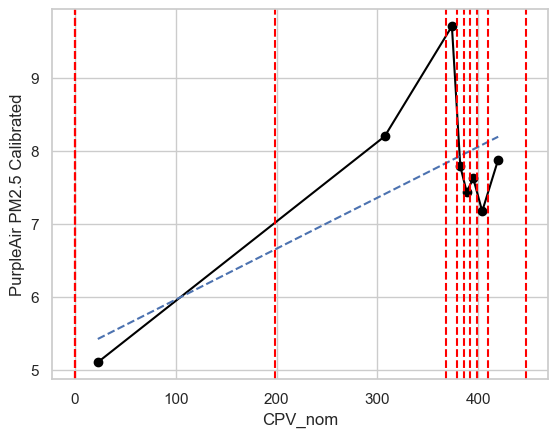

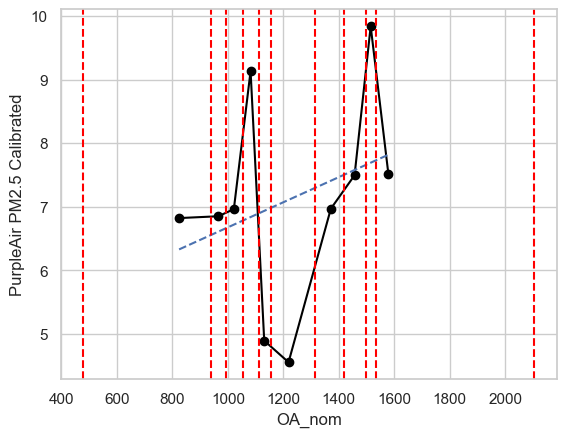

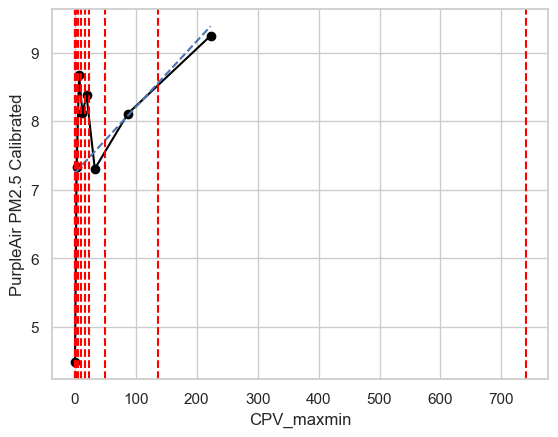

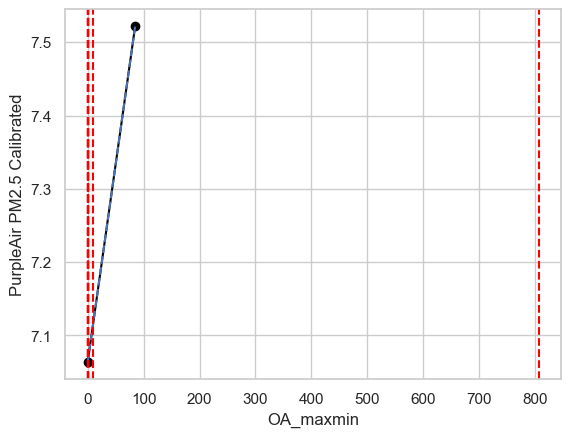

In [30]:
# Quantile Means Plots
plot_quantile_means(model_df['Quarter'], model_df['PA_PM25c'], 0.1, "Quarter", "PurpleAir PM2.5 Calibrated","Quarter")
plot_quantile_means(model_df['MoY'], model_df['PA_PM25c'], 0.1, "MoY", "PurpleAir PM2.5 Calibrated","MoY")
plot_quantile_means(model_df['DoW'], model_df['PA_PM25c'], 0.1, "DoW", "PurpleAir PM2.5 Calibrated","DoW")
plot_quantile_means(model_df['Weekday'], model_df['PA_PM25c'], 0.1, "Weekday", "PurpleAir PM2.5 Calibrated","Weekday")
plot_quantile_means(model_df['Morning'], model_df['PA_PM25c'], 0.1, "Morning", "PurpleAir PM2.5 Calibrated","Morning")
plot_quantile_means(model_df['Temp_c'], model_df['PA_PM25c'], 0.1, "Temperature", "PurpleAir PM2.5 Calibrated","PM2.5 by Temperature")
plot_quantile_means(model_df['RH_c'], model_df['PA_PM25c'], 0.1, "Relative Humidity", "PurpleAir PM2.5 Calibrated","PM2.5 by Relative Humidity")
#plot_quantile_means(model_df['tot_precip'], model_df['PA_PM25c'], 0.1, "Precip", "PurpleAir PM2.5 Calibrated","PM2.5 by Tot Precip")
#plot_quantile_means(model_df['HrlyPrecip'], model_df['PA_PM25c'], 0.1, "HrlyPrecip", "PurpleAir PM2.5 Calibrated","PM2.5 by HrlyPrecip")
plot_quantile_means(model_df['L3H_precip'], model_df['PA_PM25c'], 0.1, "L3H_precip", "PurpleAir PM2.5 Calibrated","PM2.5 by L3H Precip")
plot_quantile_means(model_df['HrlyViz'], model_df['PA_PM25c'], 0.1, "HrlyViz", "PurpleAir PM2.5 Calibrated","PM2.5 by HrlyViz")
plot_quantile_means(model_df['HrlyWindSpd'], model_df['PA_PM25c'], 0.1, "HrlyWindSpd", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly Wind Speed")
plot_quantile_means(model_df['HrlyPress'], model_df['PA_PM25c'], 0.1, "HrlyPress", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly Station Pressure")
plot_quantile_means(model_df['WindNW'], model_df['PA_PM25c'], 0.1, "WindNW", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly WindNW")
plot_quantile_means(model_df['WindSW'], model_df['PA_PM25c'], 0.1, "WindSW", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly WindSW")
plot_quantile_means(model_df['WindNE'], model_df['PA_PM25c'], 0.1, "WindNE", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly WindNE")
plot_quantile_means(model_df['CPV_nom'], model_df['PA_PM25c'], 0.1, "CPV_nom", "PurpleAir PM2.5 Calibrated","PM2.5 by CPV_nom")
plot_quantile_means(model_df['OA_nom'], model_df['PA_PM25c'], 0.1, "OA_nom", "PurpleAir PM2.5 Calibrated","PM2.5 by OA_nom")
plot_quantile_means(model_df['CPV_maxmin'], model_df['PA_PM25c'], 0.1, "CPV_maxmin", "PurpleAir PM2.5 Calibrated","PM2.5 by CPV_maxmin")
plot_quantile_means(model_df['OA_maxmin'], model_df['PA_PM25c'], 0.1, "OA_maxmin", "PurpleAir PM2.5 Calibrated","PM2.5 by OA_maxmin")
#plot_quantile_means(model_df['Hrly_Traffic'], model_df['PA_PM25c'], 0.1, "Hrly_Traffic", "PurpleAir PM2.5 Calibrated","PM2.5 by Hrly_Traffic")
#plot_quantile_means(exp_dev['snowfall'], exp_dev['PA_PM25c'], 0.1, "Snowfall", "PurpleAir PM2.5 Calibrated","PM2.5 by Snowfall")

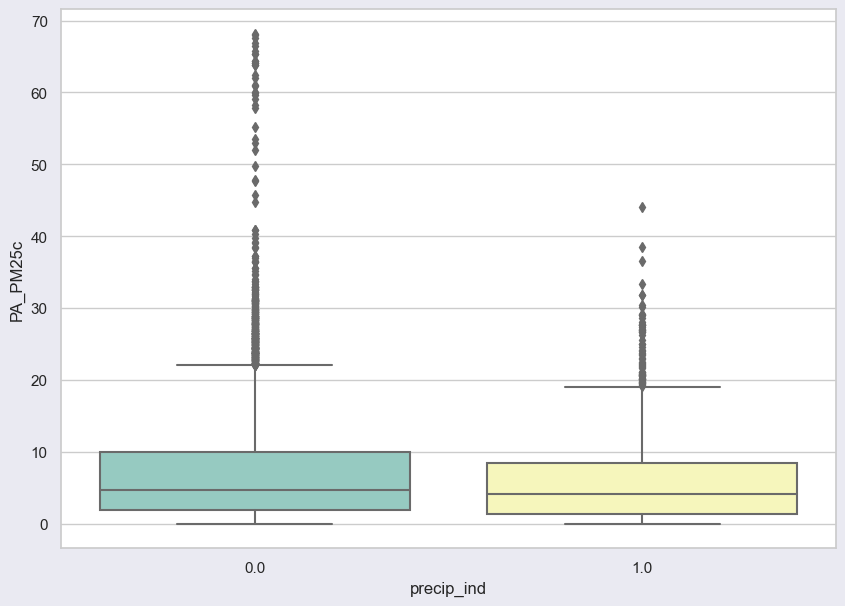

In [31]:
# Some boxplots...

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 7), facecolor=facecolor)
#ax = sns.boxplot(data=model_df, palette='Set3', x="precip_ind", y='PA_PM25c', hue='Morning')
ax = sns.boxplot(data=model_df, palette='Set3', x="precip_ind", y='PA_PM25c')
plt.show()
#plt.plot(model_df.precip_ind, model_df.PA_PM25c)
#plt.show()

**MODELING DAILY SUMMARY DATA**

In [32]:
# Model Daily Stats (mean, max, etc.)

tmp=model_df.groupby('DayNum').mean()
#print(tmp.head(5))
#print(tmp.dtypes)
#print(tmp)
#print(tmp.y1.describe())

tmp['CPV_nom2']=tmp['CPV_nom']**2
tmp['OA_nom2']=tmp['OA_nom']**2
tmp['OA_nom3']=tmp['OA_nom']**3
tmp['Temp_c2']=tmp['Temp_c']**2
tmp['Temp_c3']=tmp['Temp_c']**3
tmp['RH_c2']=tmp['RH_c']**2

# Xd = tmp[['CPV_nom','OA_nom','CPV_maxmin','OA_maxmin']] # Energy Variables Only

# STARTING MODEL
Xd = tmp[['CPV_nom','OA_nom','Temp_c','Temp_c2','Temp_c3','RH_c','RH_c2','Weekday','Morning',
          'HrlyPrecip','HrlyViz','HrlyWindSpd', 'WindNW', 'WindSW', 'WindNE',
          'L3H_precip','CPV_maxmin','OA_maxmin',
          'L3H_Temp','L3H_RH','L3H_WindSpd',
          'Yday_Temp','Yday_RH','Yday_WindSpd','Yday_Precip']] # Main Effects, no AR

# LONG MEADOW
#Xd = tmp[['Temp_c','RH_c',
#          'CPV_maxmin','OA_maxmin',
#          'Yday_Temp','Yday_WindSpd','Yday_PM2.5']] # model from LCF (hrly)
# Order of runs/removal...
# no Morning
# no Yday_Precip
# no HrlyViz
# no L3H_Precip
# no RH_c2
# no WindNW
# no Yday_RH
# no L3H_Temp
# no HrlyPrecip
# no Temp_c3
# no Weekday
# no HrlyWindSpd
# no CPV_nom
# no WindSW
# no OA_nom
# no Temp_c2
# no L3H_RH
# no WindNE
# no L3H_WindSpd
# +Yday_PM2.5

# LAKE ZOAR
#Xd = tmp[['OA_nom','HrlyWindSpd','Yday_RH','Yday_Precip','Yday_PM2.5']]

#Xd = tmp[['OA_nom','HrlyWindSpd','Yday_RH','Yday_Precip','Yday_PM2.5']] # model from LCF (hrly)
# Order of runs/removal...
# no Morning
# no RH_c2
# no HrlyPrecip
# no HrlyViz, Weekday
# no Temp_c3, Temp_c2
# no Temp_c
# no L3H_Temp
# no CPV_maxmin
# no Yday_Temp
# no CPV_nom
# no WindNE
# no WindSW
# no L3H_WindSpd (p-value & VIF)
# no Yday_WindSpd
# no OA_maxmin
# no L3H_precip
# no WindNW
# no L3H_RH
# no RH_c
# +Yday_PM2.5

# GUNNTOWN
#Xd = tmp[['CPV_nom','OA_nom','Temp_c','Temp_c2','Temp_c3','RH_c','RH_c2',
#          'CPV_maxmin','L3H_WindSpd','Yday_WindSpd','Yday_Precip','Yday_PM2.5']] # model from LCF_d (daily)
Xd = tmp[['OA_nom','Temp_c','Temp_c2','Temp_c3','RH_c','RH_c2',
          'L3H_WindSpd','Yday_WindSpd','Yday_Precip','Yday_PM2.5']] # model from LCF (hrly)

# Order of runs/removal...
# Main Effects, no AR
# no WindNW, WindSW, WindNE, Morning
# no HrlyViz
# no L3H_Temp
# no Weekday
# no HrlyWindSpd
# no Yday_RH
# no OA_maxmin
# no Yday_Temp
# no CPV_maxmin
# no L3H_Precip (VIF issue)
# no L3H_RH (VIF issue)
# no HrlyPrecip
# no CPV_nom (cause of quasi-complete separation)
# +Yday_PM2.5

tmp['Yd'] = tmp.PA_PM25cd # this is for OLS
#tmp['YdL'] = tmp.y1 # this will create % of daily hours above 12 mu/m^3 for Logit

# create 0/1 variable if tmp.y1 > 30%?
tmp['YdL']=np.array(np.zeros(len(tmp.y1))) # tmp.y1 is the avg of PA_PM25c calibrated with hourly data (LCF lower than LCF_d?)
#print(len(tmp.YdL))

# Use threshold of 0.3 for avg y1 to determine YdL=1...
tmp['ndx']=np.array(np.zeros(len(tmp.y1))) 
for i in range(1,len(tmp.y1)+1):
    if tmp.y1.iloc[i-1]>=0.3:  tmp.YdL[i-1]=1 
    tmp.ndx.iloc[i-1] = i


print(tmp.YdL.describe())
#print(Xd)
#print(Yd)
print(tmp.head(5))

print(tmp.Morning.describe())
print(tmp.L3H_WindSpd.describe())

count    346.000000
mean       0.210983
std        0.408597
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: YdL, dtype: float64
          WB_PM25    PA_PM25     Temp_F         RH  Quarter  DoW  Weekday  \
DayNum                                                                      
107.0    2.262500  10.390000  73.937500  24.208750      2.0  5.0      0.0   
176.0    5.600000   4.559583  72.036250  56.213750      2.0  4.0      1.0   
177.0    8.558333   8.867083  79.072083  60.802500      2.0  5.0      0.0   
178.0   11.850000  12.361875  86.778125  55.110625      2.0  6.0      0.0   
179.0   11.329167  12.200000  87.307500  55.351667      2.0  0.0      1.0   

         Morning  MoY  tot_precip  ...        y1       CPV_nom2    OA_nom2  \
DayNum                             ...                                       
107.0   1.000000  4.0        0.11  ...  0.250000       0.000000  1510441.0   
176.0   0.666667  6.0        0.01  ...  

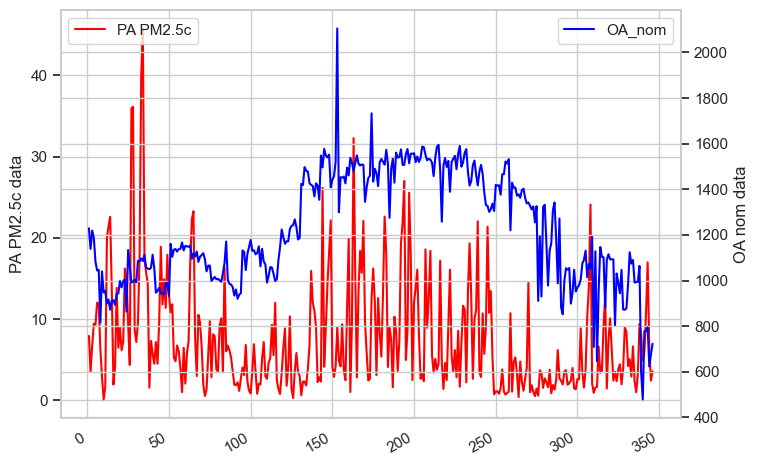

In [33]:
# plot variables

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.set_ylabel("PA PM2.5c data")
ax2.set_ylabel("OA nom data")
ax1.plot(tmp.ndx, tmp.PA_PM25cd, color = 'red', label = 'PA PM2.5c')
ax2.plot(tmp.ndx, tmp.OA_nom, color = 'blue', label = 'OA_nom')
fig.autofmt_xdate()

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

346


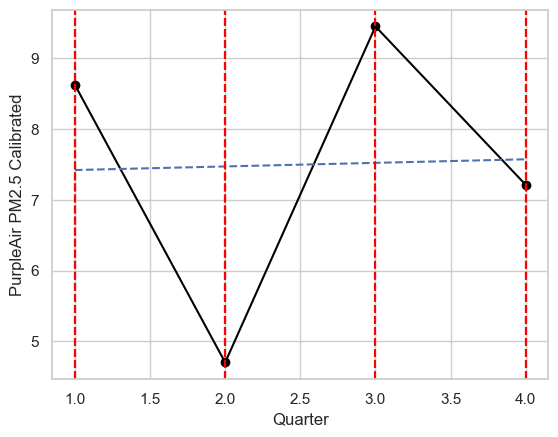

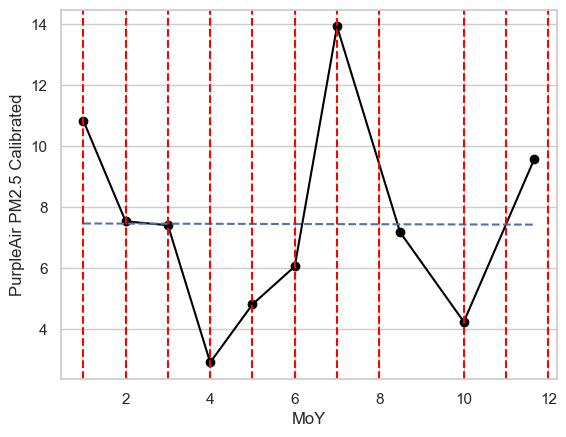

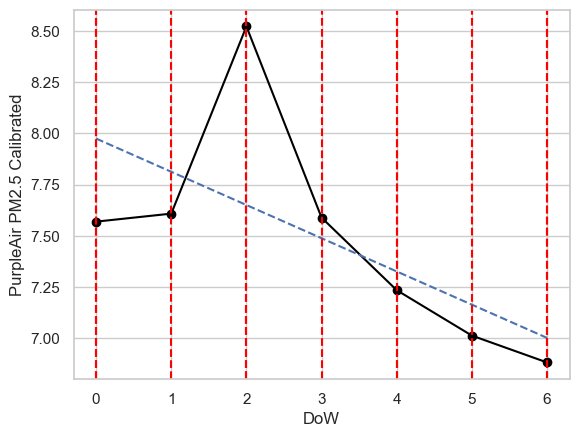

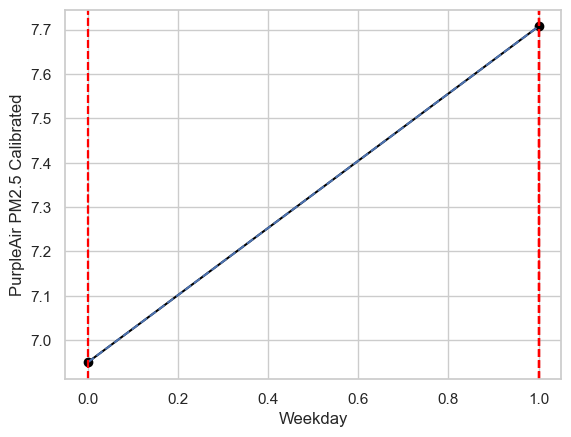

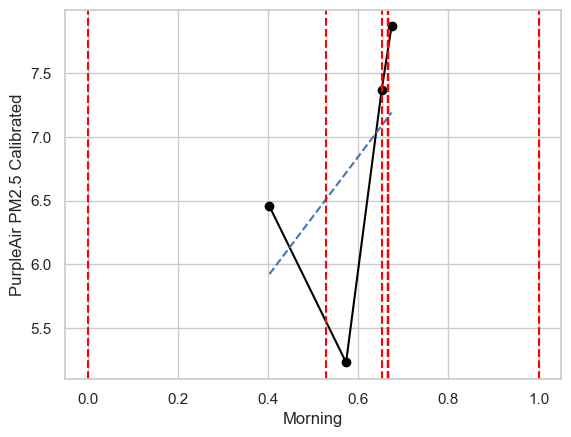

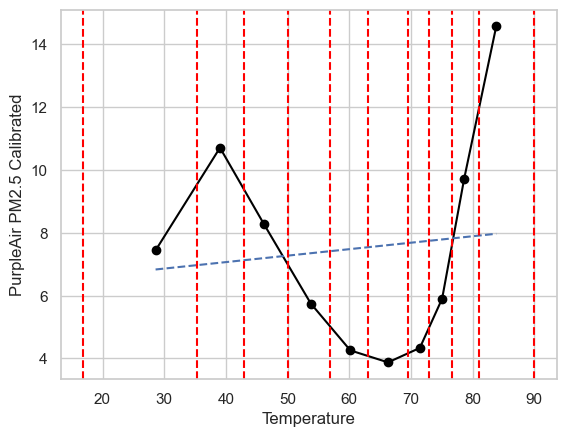

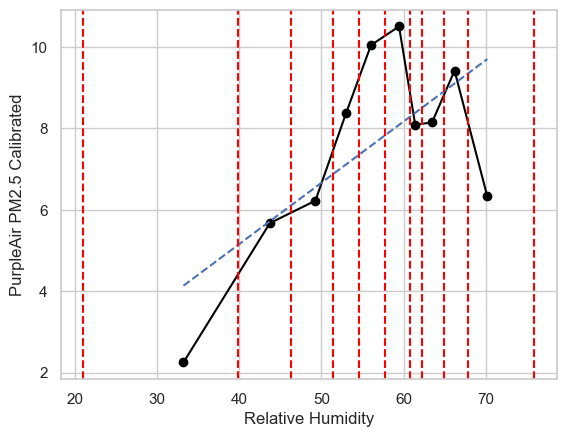

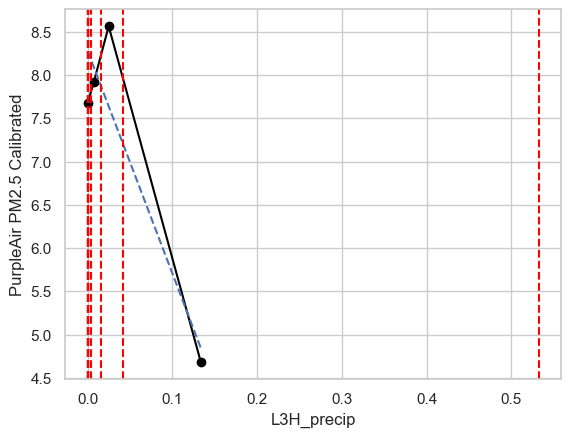

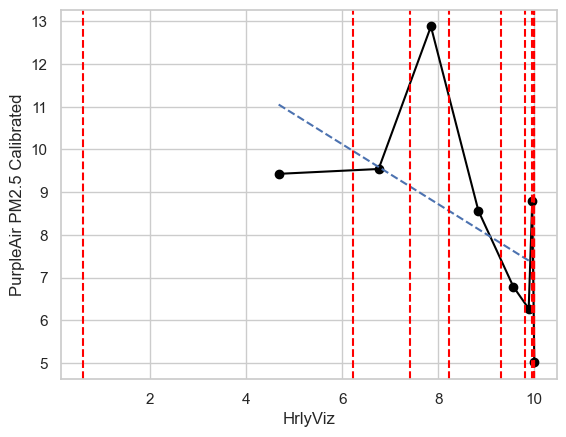

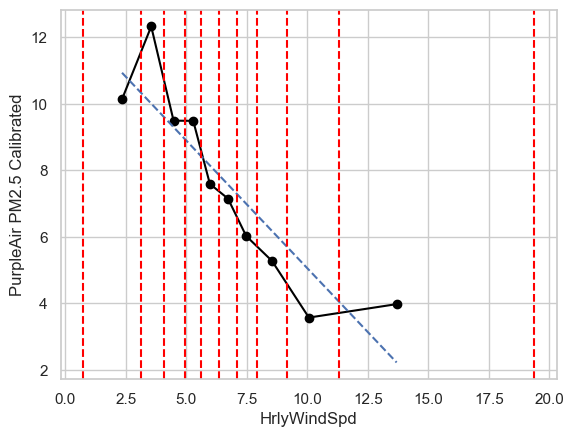

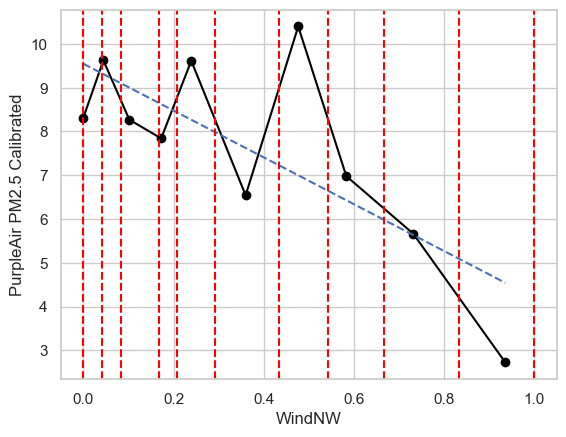

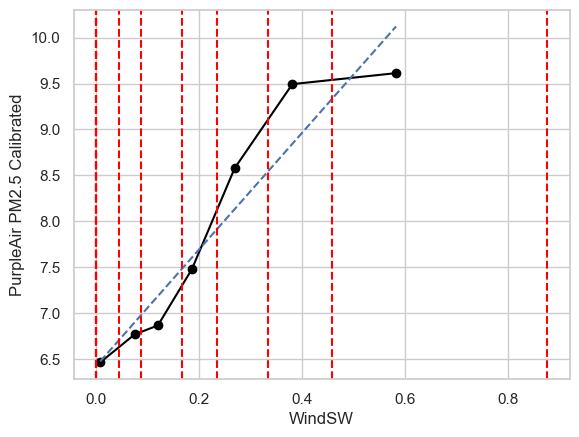

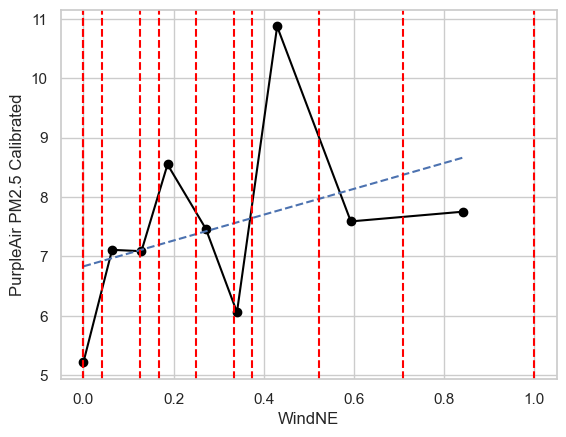

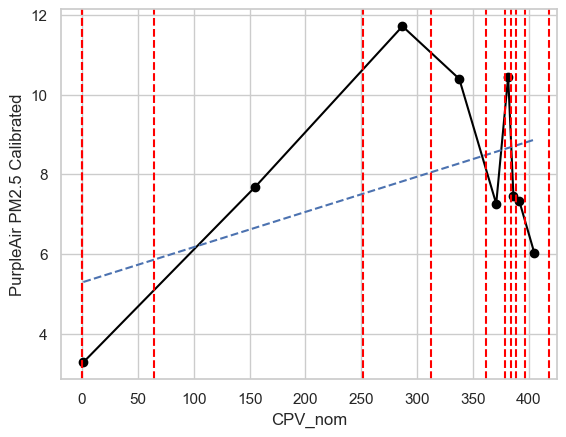

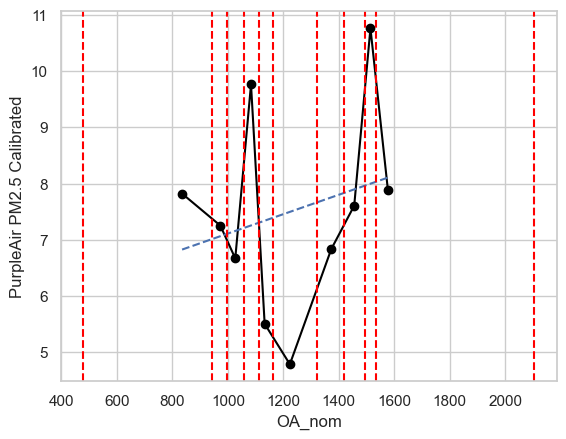

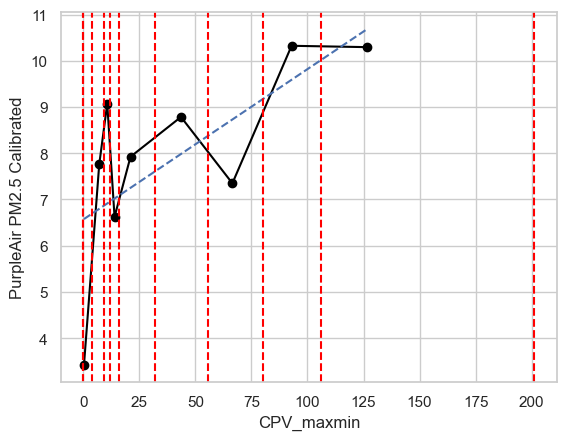

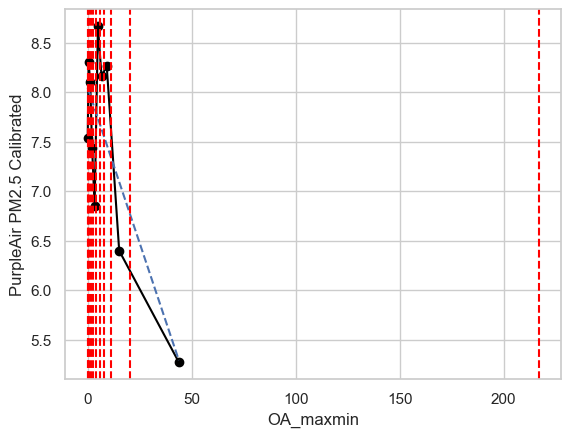

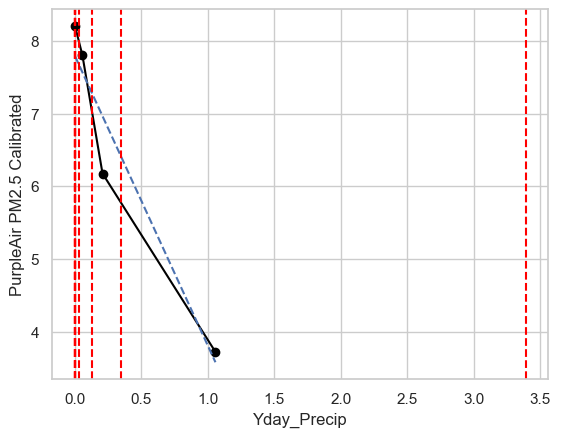

In [34]:
# Univariate Plots Using Quantile Means...
print(len(tmp))
plot_quantile_means(tmp['Quarter'], tmp['PA_PM25cd'], 0.1, "Quarter", "PurpleAir PM2.5 Calibrated","Quarter")
plot_quantile_means(tmp['MoY'], tmp['PA_PM25cd'], 0.1, "MoY", "PurpleAir PM2.5 Calibrated","MoY")
plot_quantile_means(tmp['DoW'], tmp['PA_PM25cd'], 0.1, "DoW", "PurpleAir PM2.5 Calibrated","DoW")
plot_quantile_means(tmp['Weekday'], tmp['PA_PM25cd'], 0.1, "Weekday", "PurpleAir PM2.5 Calibrated","Weekday")
plot_quantile_means(tmp['Morning'], tmp['PA_PM25cd'], 0.1, "Morning", "PurpleAir PM2.5 Calibrated","Morning")
plot_quantile_means(tmp['Temp_c'], tmp['PA_PM25cd'], 0.1, "Temperature", "PurpleAir PM2.5 Calibrated","PM2.5 by Temperature")
plot_quantile_means(tmp['RH_c'], tmp['PA_PM25cd'], 0.1, "Relative Humidity", "PurpleAir PM2.5 Calibrated","PM2.5 by Relative Humidity")
plot_quantile_means(tmp['L3H_precip'], tmp['PA_PM25cd'], 0.1, "L3H_precip", "PurpleAir PM2.5 Calibrated","PM2.5 by L3H Precip")
plot_quantile_means(tmp['HrlyViz'], tmp['PA_PM25cd'], 0.1, "HrlyViz", "PurpleAir PM2.5 Calibrated","PM2.5 by HrlyViz")
plot_quantile_means(tmp['HrlyWindSpd'], tmp['PA_PM25cd'], 0.1, "HrlyWindSpd", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly Wind Speed")
plot_quantile_means(tmp['WindNW'], tmp['PA_PM25cd'], 0.1, "WindNW", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly WindNW")
plot_quantile_means(tmp['WindSW'], tmp['PA_PM25cd'], 0.1, "WindSW", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly WindSW")
plot_quantile_means(tmp['WindNE'], tmp['PA_PM25cd'], 0.1, "WindNE", "PurpleAir PM2.5 Calibrated","PM2.5 by Oxford Hourly WindNE")
plot_quantile_means(tmp['CPV_nom'], tmp['PA_PM25cd'], 0.1, "CPV_nom", "PurpleAir PM2.5 Calibrated","PM2.5 by CPV_nom")
plot_quantile_means(tmp['OA_nom'], tmp['PA_PM25cd'], 0.1, "OA_nom", "PurpleAir PM2.5 Calibrated","PM2.5 by OA_nom")
plot_quantile_means(tmp['CPV_maxmin'], tmp['PA_PM25cd'], 0.1, "CPV_maxmin", "PurpleAir PM2.5 Calibrated","PM2.5 by CPV_maxmin")
plot_quantile_means(tmp['OA_maxmin'], tmp['PA_PM25cd'], 0.1, "OA_maxmin", "PurpleAir PM2.5 Calibrated","PM2.5 by OA_maxmin")
plot_quantile_means(tmp['Yday_Precip'], tmp['PA_PM25cd'], 0.1, "Yday_Precip", "PurpleAir PM2.5 Calibrated","PM2.5 by Yday_Precip")



In [35]:
# OLS Regression Results FOR DAILY DATA
Xd_C = sm.add_constant(Xd) # adding a column of 1's for the intercept
#print(Xd_C)
res1d = sm.OLS(tmp.Yd, Xd_C).fit() # very efficient command for OLS
print(res1d.summary())

                            OLS Regression Results                            
Dep. Variable:                     Yd   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     29.60
Date:                Wed, 05 Jul 2023   Prob (F-statistic):           1.52e-40
Time:                        09:28:30   Log-Likelihood:                -1049.9
No. Observations:                 346   AIC:                             2122.
Df Residuals:                     335   BIC:                             2164.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.2307      9.538     -1.492   

In [36]:
# Check Variance Inflation Factors; all values other than for polynomial variables should be < 5 or 10
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Xd_C.values, i) for i in range(Xd_C.shape[1])]
vif["features"] = Xd_C.columns # Associate VIFs with column names
print('VIF for Local Explanatory Regression: With Corrected PM25:')
print("\n")
print(vif.round(1)) # Print out VIFs - problematic if > 5 (or 10)

VIF for Local Explanatory Regression: With Corrected PM25:


    VIF Factor      features
0       1204.1         const
1          3.9        OA_nom
2        890.4        Temp_c
3       4429.2       Temp_c2
4       1383.9       Temp_c3
5         73.7          RH_c
6         71.3         RH_c2
7          1.4   L3H_WindSpd
8          1.9  Yday_WindSpd
9          1.2   Yday_Precip
10         1.3    Yday_PM2.5


In [37]:
# Logistic regression model - Robust - FOR DAILY DATA
LO1d = sm.Logit(tmp.YdL,Xd_C) # Xd_C same as OLS
res2d = LO1d.fit(cov_type="hc0") #heteroscedasticity robust covariance = "hc0"
# Source: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html
print(res2d.summary())

Optimization terminated successfully.
         Current function value: 0.337024
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                    YdL   No. Observations:                  346
Model:                          Logit   Df Residuals:                      335
Method:                           MLE   Df Model:                           10
Date:                Wed, 05 Jul 2023   Pseudo R-squ.:                  0.3459
Time:                        09:28:31   Log-Likelihood:                -116.61
converged:                       True   LL-Null:                       -178.28
Covariance Type:                  hc0   LLR p-value:                 1.063e-21
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -53.6697     15.577     -3.446      0.001     -84.199     -23.140
OA_nom           0.003

count    3.110000e+02
mean     1.864952e-01
std      2.256996e-01
min      1.005502e-07
25%      1.713411e-02
50%      9.183703e-02
75%      2.796131e-01
max      9.268424e-01
Name: y_predictd, dtype: float64
KS: 0.6472 (p-value: 2.077e-19)
ROC AUC: 0.8799


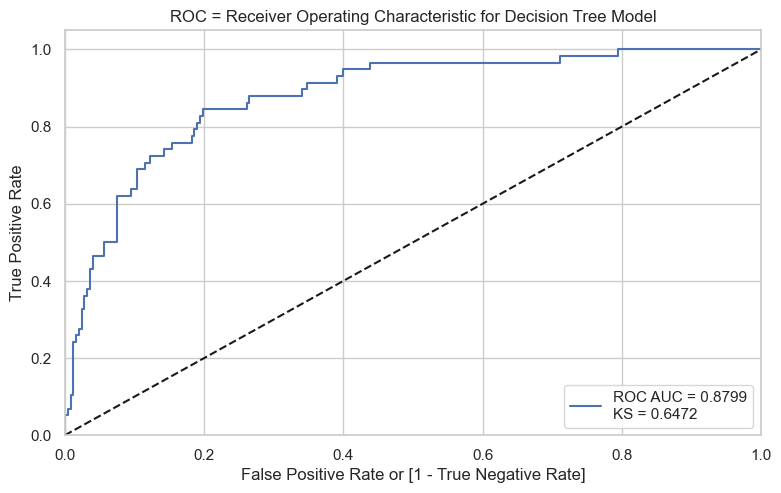

In [227]:
# Evaluate KS & ROC...
tmp['y_predictd'] = res2d.predict(Xd_C)
print(tmp.y_predictd.describe())

ks_good, auc_good = evaluate_ks_and_roc_auc(tmp['YdL'], tmp['y_predictd'])

**MODELING HOURLY DATA**

In [228]:
# Define non-linear variables

model_df['CPV_nom2']=model_df['CPV_nom']**2
model_df['OA_nom2']=model_df['OA_nom']**2
model_df['OA_nom3']=model_df['OA_nom']**3
model_df['Temp_c2']=model_df['Temp_c']**2
model_df['Temp_c3']=model_df['Temp_c']**3

model_df['Temp_cF']=np.array(np.zeros(len(model_df.Temp_c))+1) # 
print(model_df.Temp_cF)
print(model_df.Temp_c)

for i in range(1,len(model_df['Temp_cF'])+1):
    if model_df['Temp_c'].iloc[i-1]>32:  model_df['Temp_cF'].iloc[i-1]=(model_df['Temp_c'].iloc[i-1]-60)**2 # 

model_df['RH_c2']=model_df['RH_c']**2
model_df['RH_cF']=(model_df['RH_c']-60)**2

#X = model_df[['CPV_norm','OA_norm','Temp_F','RH','Weekday','Morning','HrlyPrecip','HrlyViz','HrlyWindSpd', 'WindNW', 'WindSW', 'WindNE']] 
X = model_df[['CPV_nom','CPV_nom2','OA_nom','OA_nom2','OA_nom3','Temp_c','Temp_c2','Temp_c3','Temp_cF','RH_c','RH_c2','RH_cF',
              'Weekday','Morning',
              'HrlyPrecip','HrlyViz','HrlyWindSpd', 'WindNW', 'WindSW', 'WindNE',
              'L3H_precip','CPV_maxmin','OA_maxmin',
              'L3H_Temp','L3H_RH','L3H_WindSpd','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_PM2.5']]

# Gunntown
X = model_df[['CPV_nom','OA_nom','Temp_cF','RH_cF','Morning',
              'L3H_WindSpd','Yday_WindSpd','Yday_Precip','Yday_PM2.5']]

# Use the line below for AR modeling
#          'L3H_PM2.5','L3H_Temp','L3H_RH','L3H_WindSpd','Yday_PM2.5','Yday_Temp','Yday_RH','Yday_WindSpd']]

Y = model_df.PA_PM25c

# Set up supervising variable
#y0=np.array(model_df.PA_PM25c) # Creating first variable - this will be exp_dev.PA_PM25c
#y1=np.array(np.zeros(len(model_df.PA_PM25c))) # Creating y1 variable (all set to zero for now) - this will be our target variable of 0/1's
#for i in range(1,len(y0)+1):
#    if y0[i-1]>=12:  y1[i-1]=1 # Check if 1st variable is >= 12 then set 2nd variable to 1

#print(y0,y1) # makes y1=1 if PA_PM2.5c > threshold (10, 30, etc.)
#Y = y1
#Y = (model_df.PA_PM25c)**(0.25) # Tukey transformation
#Y = model_df.PA_PM25bc

# Checking the predictors
print(Y)
print(X)

1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
       ... 
7148    1.0
7149    1.0
7150    1.0
7151    1.0
7152    1.0
Name: Temp_cF, Length: 7150, dtype: float64
1       81.81
2       79.57
3       78.83
4       78.77
5       78.20
        ...  
7148    98.50
7149    92.27
7150    90.37
7151    87.50
7152    83.50
Name: Temp_c, Length: 7150, dtype: float64
1       3.656148
2       4.163023
3       4.379068
4       4.644970
5       4.786230
          ...   
7148    1.138392
7149    1.528935
7150    1.462459
7151    1.736670
7152    2.758730
Name: PA_PM25c, Length: 7150, dtype: float64
      CPV_nom  OA_nom    Temp_cF      RH_cF  Morning  L3H_WindSpd  \
1       387.0  1244.0   475.6761  2063.8849      0.0    13.333333   
2       400.0  1132.0   382.9849   102.0100      1.0     3.000000   
3       386.0  1132.0   354.5689   136.1889      1.0     1.000000   
4       377.0  1132.0   352.3129   139.9489      1.0     1.000000   
5       376.0  1132.0   331.2400   131.5609      1

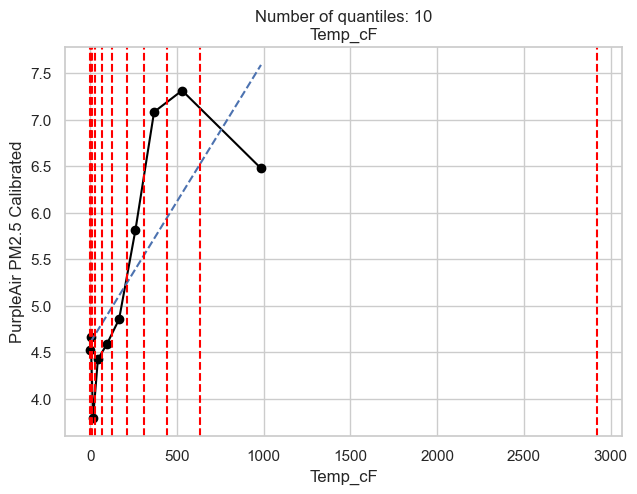

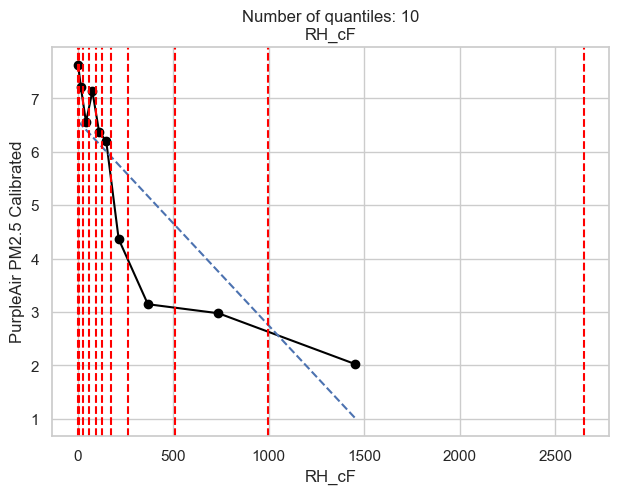

In [229]:
# Plot decile means of new variables
plot_quantile_means(model_df['Temp_cF'], model_df['PA_PM25c'], 0.1, "Temp_cF", "PurpleAir PM2.5 Calibrated","Temp_cF")
plot_quantile_means(model_df['RH_cF'], model_df['PA_PM25c'], 0.1, "RH_cF", "PurpleAir PM2.5 Calibrated","RH_cF")

## Ordinary Least Squares Regression for LER ##

In [230]:
# OLS Regression Results
X_C = sm.add_constant(X) # adding a column of 1's for the intercept
print(X_C)
res1 = sm.OLS(Y, X_C).fit() # very efficient command for OLS
print(res1.summary())

      const  CPV_nom  OA_nom    Temp_cF      RH_cF  Morning  L3H_WindSpd  \
1       1.0    387.0  1244.0   475.6761  2063.8849      0.0    13.333333   
2       1.0    400.0  1132.0   382.9849   102.0100      1.0     3.000000   
3       1.0    386.0  1132.0   354.5689   136.1889      1.0     1.000000   
4       1.0    377.0  1132.0   352.3129   139.9489      1.0     1.000000   
5       1.0    376.0  1132.0   331.2400   131.5609      1.0     1.000000   
...     ...      ...     ...        ...        ...      ...          ...   
7148    1.0    377.0   723.0  1482.2500  1281.6400      0.0     6.666667   
7149    1.0    381.0   723.0  1041.3529   930.2500      0.0     6.000000   
7150    1.0    390.0   723.0   922.3369   845.0649      0.0     6.000000   
7151    1.0    384.0   723.0   756.2500   653.8249      0.0     6.000000   
7152    1.0    383.0   723.0   552.2500   416.1600      0.0     6.333333   

      Yday_WindSpd  Yday_Precip  Yday_PM2.5  
1         4.541667         0.00   83.7400

In [231]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_C.values, i) for i in range(X_C.shape[1])]
vif["features"] = X_C.columns # Associate VIFs with column names
print('VIF for Local Explanatory Regression: With Corrected PM25:')
print("\n")
vif.round(1) # Print out VIFs - problematic if > 5 (or 10)


VIF for Local Explanatory Regression: With Corrected PM25:




VIF Factor      features
0        38.1         const
1         1.1       CPV_nom
2         1.1        OA_nom
3         1.2       Temp_cF
4         1.5         RH_cF
5         1.4       Morning
6         1.2   L3H_WindSpd
7         1.5  Yday_WindSpd
8         1.1   Yday_Precip
9         1.2    Yday_PM2.5

## Decision Tree Regression

In [232]:
# Set up supervising variable for HOURLY model
y0=np.array(model_df.PA_PM25c) # Creating first variable - this will be exp_dev.PA_PM25c
y1=np.array(np.zeros(len(model_df.PA_PM25c))) # Creating y1 variable (all set to zero for now) - this will be our target variable of 0/1's


#X1 = model_df[['CPV_nom','OA_nom','Temp_F','RH','Weekday','Morning',
#               'HrlyPrecip','HrlyViz','HrlyWindSpd','WindNW','WindSW','WindNE',
#               'L3H_precip','CPV_maxmin','OA_maxmin',
#               'L3H_Temp','L3H_RH','L3H_WindSpd','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_PM2.5']]

# Gunntown
X1 = model_df[['CPV_nom','OA_nom','Temp_cF','RH_cF','Morning',
               'L3H_WindSpd','Yday_WindSpd','Yday_Precip','Yday_PM2.5']]

        
# The creation with a new dataframe (Tried removing but new df must be created bcs of the column names will be numbered)
#env_model = pd.DataFrame(np.column_stack((y0,y1,X1)),columns=['y0','y1','CPV_nom','OA_nom','Temp_F','RH','Weekday','Morning',
#               'HrlyPrecip','HrlyViz','HrlyWindSpd','WindNW','WindSW','WindNE',
#               'L3H_precip','CPV_maxmin','OA_maxmin',
#               'L3H_Temp','L3H_RH','L3H_WindSpd','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_PM2.5'])
env_model = pd.DataFrame(np.column_stack((y0,y1,X1)),columns=['y0','y1','CPV_nom','OA_nom','Temp_cF','RH_cF','Morning',
               'L3H_WindSpd','Yday_WindSpd','Yday_Precip','Yday_PM2.5'])

                                                              
env_model

y0   y1  CPV_nom  OA_nom    Temp_cF      RH_cF  Morning  \
0     3.656148  0.0    387.0  1244.0   475.6761  2063.8849      0.0   
1     4.163023  0.0    400.0  1132.0   382.9849   102.0100      1.0   
2     4.379068  0.0    386.0  1132.0   354.5689   136.1889      1.0   
3     4.644970  0.0    377.0  1132.0   352.3129   139.9489      1.0   
4     4.786230  0.0    376.0  1132.0   331.2400   131.5609      1.0   
...        ...  ...      ...     ...        ...        ...      ...   
7145  1.138392  0.0    377.0   723.0  1482.2500  1281.6400      0.0   
7146  1.528935  0.0    381.0   723.0  1041.3529   930.2500      0.0   
7147  1.462459  0.0    390.0   723.0   922.3369   845.0649      0.0   
7148  1.736670  0.0    384.0   723.0   756.2500   653.8249      0.0   
7149  2.758730  0.0    383.0   723.0   552.2500   416.1600      0.0   

      L3H_WindSpd  Yday_WindSpd  Yday_Precip  Yday_PM2.5  
0       13.333333      4.541667         0.00   83.740000  
1        3.000000      3.791667         0.02    5.963333  
2        1.000000      3.791667         0.02    5.963333  
3        1.000000      3.791667         0.02    5.963333  
4        1.000000      3.791667         0.02    5.963333  
...           ...           ...          ...         ...  
7145     6.666667      5.916667         0.00    1.183333  
7146     6.000000      5.916667         0.00    1.183333  
7147     6.000000      5.916667         0.00    1.183333  
7148     6.000000      5.916667         0.00    1.183333  
7149     6.333333      5.916667         0.00    1.183333  

[7150 rows x 11 columns]

In [233]:
# Establish threshold for HIGH VALUES of calibrated PM2.5; can vary this value...

for i in range(1,len(env_model.y0)+1):
    if env_model.y0.iloc[i-1]>=12:  env_model.y1.iloc[i-1]=1 # Check if 1st variable is >= 10 (Before it was 10) then set 2nd variable to 1
print(env_model.y0,env_model.y1) # makes y1=1 if PA_PM2.5c > threshold (10, 30, etc.)
#https://www.indoorairhygiene.org/pm2-5-explained/#:~:text=Most%20studies%20indicate%20PM2.,breathing%20issues%20such%20as%20asthma.

env_model.y1.describe()

0       3.656148
1       4.163023
2       4.379068
3       4.644970
4       4.786230
          ...   
7145    1.138392
7146    1.528935
7147    1.462459
7148    1.736670
7149    2.758730
Name: y0, Length: 7150, dtype: float64 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7145    0.0
7146    0.0
7147    0.0
7148    0.0
7149    0.0
Name: y1, Length: 7150, dtype: float64


count    7150.000000
mean        0.137203
std         0.344085
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: y1, dtype: float64

In [234]:
# Decision Tree Regression

#features = ['CPV_nom','OA_nom','Temp_c','RH_c','Weekday','Morning',
#               'HrlyPrecip','HrlyViz','HrlyWindSpd','WindNW','WindSW','WindNE',
#               'L3H_precip','CPV_maxmin','OA_maxmin',
#               'L3H_Temp','L3H_RH','L3H_WindSpd','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_PM2.5']
features = ['CPV_nom','OA_nom','Temp_cF','RH_cF','Morning',
               'L3H_WindSpd','Yday_WindSpd','Yday_Precip','Yday_PM2.5']

# Use the line below for AR modeling
#          'L3H_PM2.5','L3H_Temp','L3H_RH','L3H_WindSpd','Yday_PM2.5','Yday_Temp','Yday_RH','Yday_WindSpd']]]

target = ['env_model.y1'] # our variable of interest (y variable)


In [235]:
#regr_1 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=30) #From 10 to 30 # Build a tree (or bush) of limited depth and minimum leaf size #regr_2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10) # A tree of a bit more depth regr_1.fit(X1, env_model.y1) # One model for each depth #regr_2.fit(X_train, Y_train)

# Regression
regr_1 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=100) # Build a tree (or bush) of limited depth and minimum leaf size
#regr_2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10) # A tree of a bit more depth
regr_1.fit(X1, env_model.y1) # One model for each depth
#regr_2.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=100)

# Plot the tree


In [236]:
## Plotting the Decsion Tree
# There is an issue with arrow color, resolved with dark background...
# https://github.com/scikit-learn/scikit-learn/issues/16943
# https://github.com/scikit-learn/scikit-learn/issues/13971
#plt.style.use('fivethirtyeight')
#plt.figure(figsize=(40,16))
#mpl.rcParams['text.color'] = 'black'
#tree.plot_tree(regr_1, feature_names=features, filled=True)
#plt.title("TREE REGRESSION:  MAX DEPTH=4, MIN LEAF=100, THRESHOLD=12", color="black")
#plt.show()
# YES to the condition (to the left) and NO to the condition (to the right)
#tree.plot_tree(regr_2, fbeature_names=features, filled=True)
#plt.title("TREE REGRESSION:  MAX DEPTH=3, MIN LEAF=10", color="w")
#plt.show()


KS: 0.5745 (p-value: 5.080e-262)
ROC AUC: 0.8640


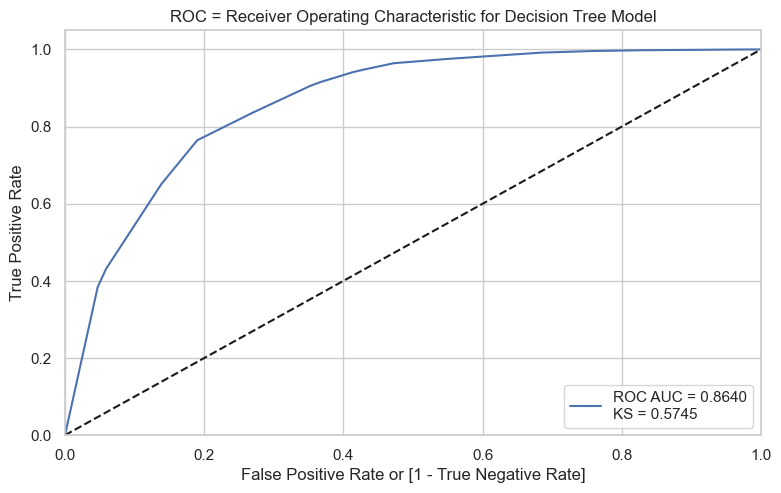

In [237]:
# Evaluate KS & ROC for the Decision Tree

y_predict2 = regr_1.predict(X1)

ks_good, auc_good = evaluate_ks_and_roc_auc(env_model.y1, y_predict2)

In [238]:
print('Mean:',np.mean(y_predict2),
      'Max:',np.max(y_predict2),
      'Min:',np.min(y_predict2),
      'Count:',np.count_nonzero(y_predict2),
      'Unique:',np.unique(y_predict2))

Mean: 0.1372027972027972 Max: 0.5652173913043478 Min: 0.0 Count: 7041 Unique: [0.         0.00209424 0.00460829 0.00879121 0.01891253 0.02235772
 0.05776173 0.06306306 0.08090615 0.09708738 0.11785095 0.125
 0.25934579 0.30551627 0.38333333 0.56521739]


KS: 0.6899 (p-value: 2.380e-22)
ROC AUC: 0.9126


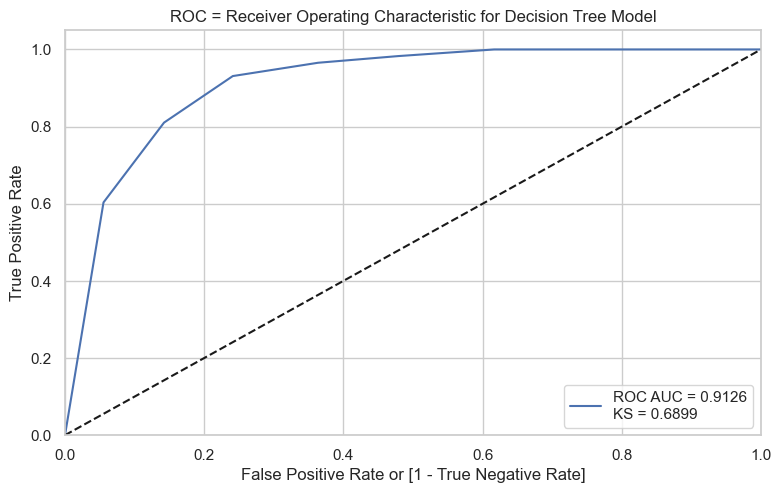

In [239]:
# Regression Tree for DAILY DATA

Xd = tmp[['CPV_nom','OA_nom','Temp_c','Temp_c2','Temp_c3','RH_c','RH_c2','Weekday','Morning',
          'HrlyPrecip','HrlyViz','HrlyWindSpd', 'WindNW', 'WindSW', 'WindNE',
          'L3H_precip','CPV_maxmin','OA_maxmin',
          'L3H_Temp','L3H_RH','L3H_WindSpd','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_PM2.5']]

features = ['CPV_nom','OA_nom','Temp_c','Temp_c2','Temp_c3','RH_c','RH_c2','Weekday','Morning',
               'HrlyPrecip','HrlyViz','HrlyWindSpd','WindNW','WindSW','WindNE',
               'L3H_precip','CPV_maxmin','OA_maxmin',
               'L3H_Temp','L3H_RH','L3H_WindSpd','Yday_Temp','Yday_RH','Yday_WindSpd','Yday_PM2.5']

#features = ['CPV_nom','OA_nom','CPV_maxmin','OA_maxmin']

target = ['tmp.YdL'] # our variable of interest (y variable)

# Regression
regr_d = DecisionTreeRegressor(max_depth=4, min_samples_leaf=30) # Build a tree (or bush) of limited depth and minimum leaf size
#regr_2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10) # A tree of a bit more depth
regr_d.fit(Xd, tmp.YdL) # One model for each depth
#regr_2.fit(X_train, Y_train)

#plt.style.use('fivethirtyeight')
#plt.figure(figsize=(40,16))
#mpl.rcParams['text.color'] = 'black'
#tree.plot_tree(regr_d, feature_names=features, filled=True)
#plt.title("TREE REGRESSION:  MAX DEPTH=4, MIN LEAF=30, THRESHOLD=12", color="black")
#plt.show()

y_predictd_tree = regr_d.predict(Xd)

ks_good, auc_good = evaluate_ks_and_roc_auc(tmp.YdL, y_predictd_tree)

### LOGISTIC Regression for HOURLY LER

In [240]:
print(model_df.isna().sum())
print(len(model_df))

DayNum          0
WB_PM25         0
PA_PM25         0
Temp_F          0
RH              0
Quarter         0
DoW             0
Weekday         0
Morning         0
MoY             0
tot_precip      0
HrlyPrecip      0
HrlyViz         0
HrlyWindSpd     0
HrlyPress       0
CPV_nom         0
OA_nom          0
WindNW          0
WindSW          0
WindNE          0
Temp_c          0
RH_c            0
L3H_precip      0
precip_ind      0
CPV_1           0
CPV_2           0
CPV_3           0
CPV_maxmin      0
OA_1            0
OA_2            0
OA_3            0
OA_maxmin       0
L3H_PM2.5       0
L3H_Temp        0
L3H_RH          0
L3H_WindSpd     0
L3H_Pressure    0
Yday_Temp       0
Yday_RH         0
Yday_WindSpd    0
Yday_Precip     0
Yday_PM2.5      0
Yday_Press      0
WB_PM25_bc      0
WB_PM25_tu      0
PA_PM25_bc      0
PA_PM25_tu      0
PA_PM25c        0
PA_PM25cd       0
y1              0
CPV_nom2        0
OA_nom2         0
OA_nom3         0
Temp_c2         0
Temp_c3         0
Temp_cF   

In [241]:
# The creation with a new dataframe (Tried removing but new df must be created bcs of the column names will be numbered
#X2 = model_df[['GrossLoad','OA_Oxford_nom']]
    
y0=np.array(model_df.PA_PM25c) # Creating first variable - this will be exp_dev.PA_PM25c
y1=np.array(np.zeros(len(model_df.PA_PM25c))) # Creating y1 variable (all set to zero for now) - this will be our target variable of 0/1's
# uniform random variable for sample selection
urv=np.random.uniform(0,1,len(model_df))

all_vars_init = pd.DataFrame(np.column_stack((urv, y0,y1,model_df['CPV_nom'],model_df['OA_nom'],model_df['CPV_maxmin'],model_df['OA_maxmin'],
                                         model_df['Temp_c'],model_df['Temp_c2'],model_df['Temp_c3'],model_df['Temp_cF'],
                                         model_df['RH_c'],model_df['RH_c2'],model_df['RH_cF'],
                                         model_df['Morning'],model_df['Weekday'],
                                         model_df['HrlyPrecip'],model_df['HrlyViz'],model_df['HrlyWindSpd'],model_df['HrlyPress'],
                                         model_df['WindNW'],model_df['WindSW'],model_df['WindNE'],
                                         model_df['L3H_precip'],model_df['L3H_Temp'],model_df['L3H_RH'],model_df['L3H_WindSpd'],model_df['L3H_Pressure'],
                                         model_df['Yday_Temp'],model_df['Yday_RH'],model_df['Yday_WindSpd'],model_df['Yday_Precip'],model_df['Yday_Press'],
                                         model_df['Yday_PM2.5'])),
                                         columns = ['urv','y0','y1','CPV_nom','OA_nom','CPV_maxmin','OA_maxmin',
                                                    'Temp_c','Temp_c2','Temp_c3','Temp_cF','RH_c','RH_c2','RH_cF','Morning','Weekday',
                                                    'HrlyPrecip','HrlyViz','HrlyWindSpd','HrlyPress',
                                                    'WindNW', 'WindSW', 'WindNE',
                                                    'L3H_precip','L3H_Temp','L3H_RH','L3H_WindSpd','L3H_Pressure',
                                                    'Yday_Temp','Yday_RH','Yday_WindSpd','Yday_Precip','Yday_Press','Yday_PM2.5']) # All variables
                        
#                                 columns=['y0','y1','CPV_nom','OA_nom','Temp_c','Temp_c2','Temp_c3','RH_c','RH_c2',
#                                          'Morning','L3H_WindSpd','Yday_WindSpd','Yday_Precip','Yday_PM2.5']) # Some variables

# if doing validation analysis on random sample then select pct to use in modeling
all_vars=all_vars_init[all_vars_init.urv<=1.0] # use threshold of 1.0 for all data

In [242]:
for i in range(1,len(all_vars.y0)+1):
    if all_vars.y0.iloc[i-1]>=12:  all_vars.y1.iloc[i-1]=1 # Check if 1st variable is >= 12 (Before it was 10) then set 2nd variable to 1
#print(all_vars.y0,all_vars.y1)
print('Obs: ',len(all_vars.y1), 'Mean:',np.mean(all_vars.y1),'Sum:',np.sum(all_vars.y1))

#all_vars.Xav = all_vars[['CPV_nom','OA_nom','CPV_maxmin','OA_maxmin',
#                         'Temp_c','Temp_c2','Temp_c3','RH_c','RH_c2','Morning','Weekday',
#                         'HrlyPrecip','HrlyViz','HrlyWindSpd',
#                         'WindNW', 'WindSW', 'WindNE',
#                         'L3H_precip','L3H_Temp','L3H_RH','L3H_WindSpd',
#                         'Yday_Temp','Yday_RH','Yday_WindSpd','Yday_Precip','Yday_PM2.5']] # base model, with A/R, Polynomial terms
all_vars.Xav = all_vars[['CPV_nom','OA_nom','CPV_maxmin','OA_maxmin',
                         'Temp_cF','RH_cF','Morning','Weekday',
                         'HrlyPrecip','HrlyViz','HrlyWindSpd','HrlyPress',
                         'WindNW', 'WindSW', 'WindNE',
                         'L3H_precip','L3H_Temp','L3H_RH','L3H_WindSpd','L3H_Pressure',
                         'Yday_Temp','Yday_RH','Yday_WindSpd','Yday_Precip','Yday_Press','Yday_PM2.5']] # base model, with A/R, Temp & RH fns
# Gunntown
all_vars.Xav = all_vars[['CPV_nom','OA_nom','CPV_maxmin',
                         'Temp_cF','RH_cF',
                         'HrlyViz','HrlyWindSpd','HrlyPress',
                         'WindNW', 'WindSW', 'WindNE',
                         'L3H_precip','L3H_WindSpd',
                         'Yday_RH','Yday_WindSpd','Yday_Precip','Yday_PM2.5']] # base model, with A/R, Temp & RH fns
# Order of removal
# HrlyPrecip, Weekday (p-value), L3H_Pressure (VIF)
# Yday_Press
# OA_maxmin
# Yday_Temp (VIF)
# Morning
# L3H_Temp
# L3H_RH
# +Yday_PM2.5

# Long Meadow
all_vars.Xav = all_vars[['CPV_nom','OA_nom','CPV_maxmin',
                         'Temp_cF','RH_cF',
                         'HrlyViz','HrlyWindSpd','HrlyPress',
                         'WindNW','WindNE',
                         'L3H_precip','L3H_Temp','L3H_RH','L3H_WindSpd',
                         'Yday_RH','Yday_WindSpd','Yday_Precip','Yday_PM2.5']]  # base model, with A/R, Temp & RH fns
# Order of removal
# L3H_Pressure
# HrlyPrecip
# Weekday, OA_maxmin
# Yday_Press (VIF)
# Yday_Temp (VIF)
# Morning
# WindSW
# +Yday_PM2.5

# Lake Zoar
#all_vars.Xav = all_vars[['CPV_nom','OA_nom','CPV_maxmin',
#                         'Temp_cF','RH_cF',
#                         'HrlyViz','HrlyWindSpd','HrlyPress',
#                         'WindNW', 'WindNE',
#                         'L3H_precip','L3H_WindSpd',
#                         'Yday_RH','Yday_WindSpd','Yday_Precip','Yday_PM2.5']] # base model, with A/R, Temp & RH fns
# Order of removal
# HrlyPrecip
# Yday_Press
# L3H_RH
# OA_maxmin
# WindSW
# L3H_Pressure (VIF)
# Yday_Temp (VIF)
# L3H_Temp
# Weekday, Morning
# +Yday_PM2.5

#print(all_vars.Xav)
#print(all_vars.y1)


Obs:  7150 Mean: 0.1372027972027972 Sum: 981.0


In [243]:
# Logistic regression model - Robust
LO1 = sm.Logit(all_vars.y1,(sm.add_constant(all_vars.Xav))) # X1 = same variable as Exp_dev 
res = LO1.fit(cov_type="hc0") #heteroscedasticity robust covariance = "hc0"
# Source: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html
res.summary()
# use predict to assign probabilities to each datapoint of new_df (will be called y1_predicted)
# predicting probability from sm.logit

Optimization terminated successfully.
         Current function value: 0.263558
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     y1   No. Observations:                 7150
Model:                          Logit   Df Residuals:                     7131
Method:                           MLE   Df Model:                           18
Date:                Sun, 21 May 2023   Pseudo R-squ.:                  0.3409
Time:                        12:17:32   Log-Likelihood:                -1884.4
converged:                       True   LL-Null:                       -2858.9
Covariance Type:                  hc0   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           49.3009      6.972      7.071      0.000      35.636      62.966
CPV_nom          0.0007      0.000      2.681      0.007       0.000       0.001
OA_nom           0.0032      0.000     10.615      0.000       0.003       0.004
CPV_maxmin       0.0040      0.001      6.449      0.000       0.003       0.005
Temp_cF          0.0015      0.000     10.310      0.000       0.001       0.002
RH_cF           -0.0016      0.000     -7.078      0.000      -0.002      -0.001
HrlyViz         -0.0860      0.014     -6.063      0.000      -0.114      -0.058
HrlyWindSpd     -0.0491      0.017     -2.861      0.004      -0.083      -0.015
HrlyPress       -1.7553      0.234     -7.507      0.000      -2.214      -1.297
WindNW          -1.1964      0.118    -10.169      0.000      -1.427      -0.966
WindNE          -0.8063      0.111     -7.265      0.000      -1.024      -0.589
L3H_precip      -7.6337      2.624     -2.909      0.004     -12.778      -2.490
L3H_Temp         0.0287      0.005      5.896      0.000       0.019       0.038
L3H_RH           0.0177      0.005      3.573      0.000       0.008       0.027
L3H_WindSpd     -0.1360      0.018     -7.525      0.000      -0.171      -0.101
Yday_RH         -0.0723      0.007    -10.936      0.000      -0.085      -0.059
Yday_WindSpd    -0.2699      0.023    -11.612      0.000      -0.315      -0.224
Yday_Precip      0.7250      0.153      4.751      0.000       0.426       1.024
Yday_PM2.5       0.0782      0.006     13.834      0.000       0.067       0.089
================================================================================
"""

In [244]:
# Check VIFs
vif = pd.DataFrame()
X_C = sm.add_constant(all_vars.Xav)
vif["VIF Factor"] = [variance_inflation_factor(X_C.values, i) for i in range(X_C.shape[1])]
vif["features"] = X_C.columns # Associate VIFs with column names
print('VIF for Local Explanatory Regression: With Corrected PM25:')
print("\n")
vif.round(1) # Print out VIFs - problematic if > 5 (or 10)

VIF for Local Explanatory Regression: With Corrected PM25:




VIF Factor      features
0      27444.5         const
1          1.1       CPV_nom
2          2.7        OA_nom
3          1.2    CPV_maxmin
4          1.2       Temp_cF
5          2.2         RH_cF
6          1.3       HrlyViz
7          3.0   HrlyWindSpd
8          1.5     HrlyPress
9          1.6        WindNW
10         1.6        WindNE
11         1.2    L3H_precip
12         3.4      L3H_Temp
13         3.2        L3H_RH
14         3.0   L3H_WindSpd
15         1.9       Yday_RH
16         1.7  Yday_WindSpd
17         1.4   Yday_Precip
18         1.4    Yday_PM2.5

In [245]:
# use predict to assign probabilities to each datapoint of new_df (will be called y1_predicted)
# add the prediction to dataframe
#new_df['y1_predicted'] = LO1.predict(sm.add_constant(new_df.Xnew))
all_vars['y1_predicted'] = res.predict(sm.add_constant(all_vars.Xav))
all_vars.y1_predicted

0       0.260199
1       0.484143
2       0.397429
3       0.513955
4       0.510662
          ...   
7145    0.008000
7146    0.024032
7147    0.007856
7148    0.007528
7149    0.021315
Name: y1_predicted, Length: 7150, dtype: float64

In [246]:
# Compute averages of Explanatory Variables to determine log-odds influence
avgs=all_vars.Xav.mean()*0.01 # 1% change (of avg) in input variable for sensitivity analysis, unless too large...
print(avgs)
print(res.params)
print(avgs[0])
print(res.params[1])

# Calculate odds influence of swing in explanatory variable
influ=np.array(np.zeros(len(avgs)))
for i in range(1,len(avgs)+1):
    influ[i-1]=np.exp(res.params[i]*avgs[i-1])
    
print(influ-1)

# Check Coefficient of Variation to gage size of 1% change
#print(np.sqrt(all_vars.Xav.var()))
#print(all_vars.Xav.mean())
print(np.sqrt(all_vars.Xav.var())/all_vars.Xav.mean())

# if CV << 1%, then use CV in influence, not 1% of avg

CPV_nom          2.633765
OA_nom          12.793752
CPV_maxmin       0.400750
Temp_cF          2.469786
RH_cF            3.178356
HrlyViz          0.087881
HrlyWindSpd      0.069213
HrlyPress        0.292514
WindNW           0.003870
WindNE           0.002948
L3H_precip       0.000151
L3H_Temp         0.557843
L3H_RH           0.531293
L3H_WindSpd      0.069105
Yday_RH          0.531162
Yday_WindSpd     0.069295
Yday_Precip      0.001159
Yday_PM2.5       0.066215
dtype: float64
const           49.300883
CPV_nom          0.000731
OA_nom           0.003183
CPV_maxmin       0.003965
Temp_cF          0.001542
RH_cF           -0.001597
HrlyViz         -0.086018
HrlyWindSpd     -0.049123
HrlyPress       -1.755337
WindNW          -1.196390
WindNE          -0.806345
L3H_precip      -7.633741
L3H_Temp         0.028730
L3H_RH           0.017722
L3H_WindSpd     -0.135995
Yday_RH         -0.072349
Yday_WindSpd    -0.269933
Yday_Precip      0.725001
Yday_PM2.5       0.078245
dtype: float64
2.633765

     MoY       urv         y0        y1     CPV_nom       OA_nom  CPV_maxmin  \
0    1.0  0.498690   8.469924  0.265753  215.909589  1505.850685   82.039726   
1    2.0  0.507404   5.708827  0.149321  263.819005  1519.325792   84.432881   
2    3.0  0.490736   6.038885  0.189821  311.682256  1434.687758   51.949106   
3    4.0  0.518050   2.016045  0.026786    0.000000  1263.926786    0.000000   
4    5.0  0.507157   4.261820  0.092517  252.239456  1012.465306   24.238095   
5    6.0  0.509391   2.966640  0.024024  380.319820   915.421922   18.006006   
6    8.0  0.510284  10.250299  0.333333  371.850575  1124.363985   29.957854   
7    9.0  0.502736   4.466627  0.067350  211.017570  1032.698389   13.064422   
8   10.0  0.496875   3.709162  0.054286  250.104286  1127.962857   13.170000   
9   11.0  0.471202   4.490193  0.099855  393.523878  1498.458755   32.506512   
10  12.0  0.500382   8.621343  0.288646  268.119015  1517.192886   74.741450   

    OA_maxmin     Temp_c      Temp_c2  

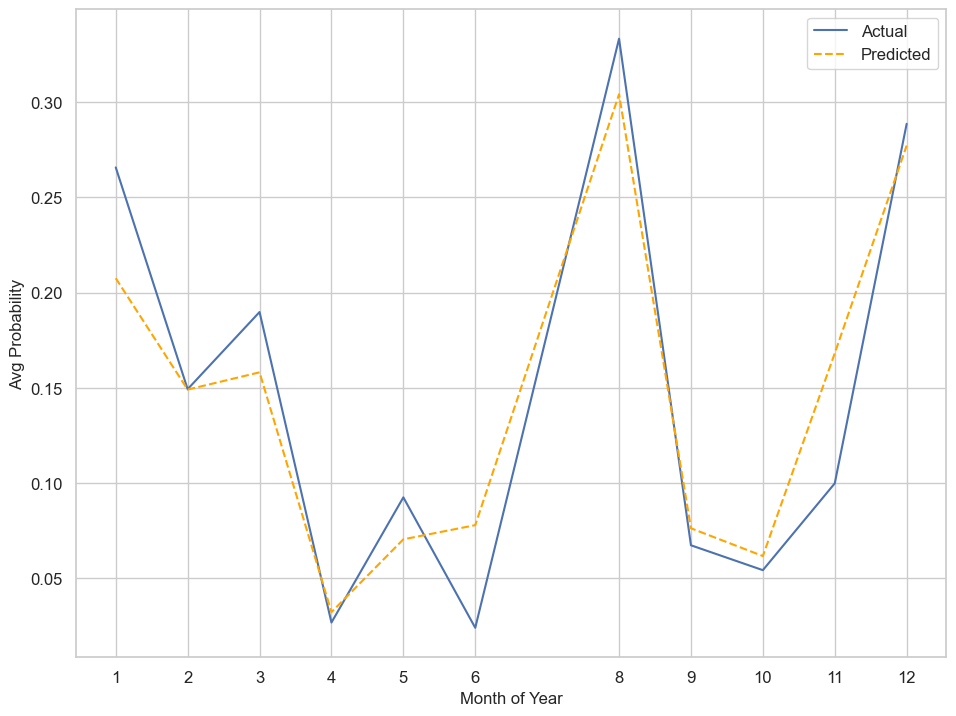

In [247]:
# plot variables

#tmp['Yd'] = tmp.PA_PM25cd # this is for OLS
#tmp['YdL'] = tmp.y1 # this will create % of daily hours above 12 mu/m^3 for Logit

# create 0/1 variable if tmp.y1 > 30%?
#tmp['YdL']=np.array(np.zeros(len(tmp.y1))) # tmp.y1 is the avg of PA_PM25c calibrated with hourly data (LCF lower than LCF_d?)
#print(len(tmp.YdL))

# Use threshold of 0.3 for avg y1 to determine YdL=1...
#tmp['ndx']=np.array(np.zeros(len(tmp.y1))) 
#for i in range(1,len(tmp.y1)+1):
#    if tmp.y1.iloc[i-1]>=0.3:  tmp.YdL[i-1]=1 
#    tmp.ndx.iloc[i-1] = i

# prepare for analysis of daily avgs
all_vars['DayNum']=model_df.DayNum
tmp2=all_vars.groupby('DayNum').mean()
# prepare for analysis of monthly avgs
all_vars['MoY']=model_df.MoY
#print(all_vars.head(5))
#tmp3=pd.DataFrame(data=all_vars.groupby("MoY").mean())
tmp3=all_vars.groupby('MoY').mean().reset_index() # ".reset_index()" puts MoY into groupby output
print(tmp3)
#x=tmp3.iloc[:,:]


#fig = plt.figure(figsize=(10,8),facecolor='white')
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.set_ylabel("PA PM2.5c data")
ax2.set_ylabel("Predicted Probability")
# plot hourly data by day
ax1.plot(model_df.DayNum, model_df.PA_PM25c, '.', color = 'orange', label = 'PA PM2.5c')
ax1.plot(model_df.DayNum, all_vars.y1, '.', color = 'blue', label = 'Indicator for PM2.5 ≥ 12 μg/m^3')
ax2.plot(model_df.DayNum, all_vars.y1_predicted, '.', color = 'orange', label = 'Prob Est')
# plot daily avgs
ax1.plot(tmp.ndx, tmp2.y1, '.', color = 'blue', label = 'Indicator for PM2.5 ≥ 12 μg/m^3')
ax2.plot(tmp.ndx, tmp2.y1_predicted, '.', color = 'orange', label = 'Prob Est')
fig.autofmt_xdate()

ax1.legend(loc = 'center left')
ax2.legend(loc = 'upper right')
plt.show()

#fig = plt.figure(figsize=(10,8),facecolor='white')
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.set_ylabel("PA PM2.5c data")
ax2.set_ylabel("Predicted Probability")
# plot hrly data by month
# plot monthly avgs
ax1.plot(tmp3.MoY, tmp3.y1, '.', color = 'blue', label = 'Indicator for PM2.5 ≥ 12 μg/m^3',linestyle='solid')
ax2.plot(tmp3.MoY, tmp3.y1_predicted, '.', color = 'orange', label = 'Prob Est',linestyle='dashed')
fig.autofmt_xdate()
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

#Print plots
fig = plt.figure(figsize=(10,8),facecolor='none')
#ax.set_facecolor('white')
#plt.rc('font', size=12)          # controls default text sizes
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.plot(tmp3.MoY,tmp3.y1)
plt.plot(tmp3.MoY,tmp3.y1_predicted, color='orange', linestyle='dashed')
#plt.xlim([1,12])
#plt.ylim([0,0.6])
plt.xlabel("Month of Year"); plt.ylabel("Avg Probability")
#plt.title("Predicted vs Actual Probability of PM2.5 ≥ 12 μg/m^3")
plt.xticks(tmp3.MoY)
#plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.legend(['Actual', 'Predicted'])
plt.show()

In [248]:
# Compute confusion matrix for hourly data...

TotPop = len(all_vars)
TP = len(all_vars.y1[all_vars.y1==1][all_vars.y1_predicted>=0.5])
FP = len(all_vars.y1[all_vars.y1==0][all_vars.y1_predicted>=0.5])
FN = len(all_vars.y1[all_vars.y1==1][all_vars.y1_predicted<0.5])
TN = len(all_vars.y1[all_vars.y1==0][all_vars.y1_predicted<0.5])
GrandTot=TP+FP+FN+TN

print(TotPop, TP, FP, FN, TN, GrandTot)
print(TP / (TP+FN)) # Recall
print(TP / (TP + FP)) # Precision
print((TP+TN) / (TP+FP+FN+TN)) # Accuracy

7150 368 189 613 5980 7150
0.3751274209989806
0.6606822262118492
0.8878321678321678


KS: 0.6544 (p-value: 3.320e-321)
ROC AUC: 0.8886


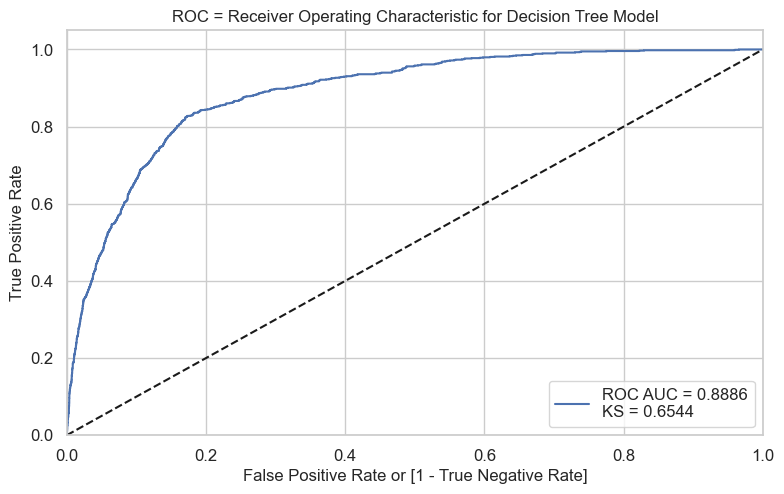

In [249]:
# Evaluate KS & ROC for the Logistic Model

ks_good, auc_good = evaluate_ks_and_roc_auc(all_vars.y1, all_vars.y1_predicted)
# this is where the df_new.y1_predicted will be only needed
# Higher the better for both

In [250]:
# list cases with highest prediction
highest=all_vars[all_vars.y1_predicted>0.9]
highest.head(10)
print(len(highest))
print(highest.mean())
print(all_vars.mean())

35
urv                  0.614486
y0                  21.967277
y1                   0.828571
CPV_nom            299.742857
OA_nom            1440.771429
CPV_maxmin         119.485714
OA_maxmin            9.942857
Temp_c              52.708857
Temp_c2           3447.507266
Temp_c3         277564.480040
Temp_cF            722.444409
RH_c                60.280286
RH_c2             3798.581449
RH_cF              164.947163
Morning              0.800000
Weekday              0.685714
HrlyPrecip           0.002000
HrlyViz              4.914286
HrlyWindSpd          3.600000
HrlyPress           29.009429
WindNW               0.085714
WindSW               0.371429
WindNE               0.371429
L3H_precip           0.003143
L3H_Temp            51.744762
L3H_RH              60.279048
L3H_WindSpd          2.838095
L3H_Pressure        29.022286
Yday_Temp           47.788321
Yday_RH             51.914345
Yday_WindSpd         3.267547
Yday_Precip          0.090286
Yday_Press          29.061507
Yday_PM

# END OF PROGRAM